# Neural Dependency Parsing With BERT and BiLSTM Contextual Emeddings

Cesare Bidini

n°matricola: 2088616

In [ ]:
!pip install datasets  # huggingface library with dataset
!pip install conllu    # aux library for processing CoNLL-U format
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 9.9 MB/s eta 0:00:00


In [ ]:
%%capture
!pip install wandb
!pip install --upgrade wandb

In [ ]:
import torch
import torch.nn as nn
from functools import partial
from datasets import load_dataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
import seaborn as sns
from tabulate import tabulate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm
import numpy as np

In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Introduction
In this notebook, two models of neural dependency parsing will be presented.  The first model use representations obtained from a BiLSTM while the second leverages representations from BERT fine-tuned. The model will output predicted dependency trees from input sentences.

A dependency tree is a formalism that describe the syntactic structure of a sentence, given the words in it and the directed grammatical relations among them. Unlike phrase structures, dependency trees do not directly model costituencies.

We will use UD dataset for this task and UAS as evaluation metric. Since our model will act as an oracle for the parser(i.e. provide a transition operator) at each step, we need the ground truths(labels) for each of these steps in order to train it.

So, first of all, we will use Arc-eager and the gold dependency trees from the dataset to produce our set of gold transitions.

# Arc-Eager

This notebook implements the `Arc-Eager` parser, as described in the paper <font color='lightblue'> "A Dynamic Oracle for Arc-Eager Dependency Parsing" </font> by Y. Goldberg and J. Nivre.

Four transition operators are defined:

- <font color='white'>Left-arc:</font> Pops the top-most element of the stack and attaches it as a dependent of the first element in the buffer.

- <font color='white'>Right-arc:</font> Attaches the first element in the buffer as a dependent of the top-most element in the stack, then pushes the first buffer element into the stack.

- <font color='white'>Reduce:</font> Pops the top-most element from the stack.

- <font color='white'>Shift:</font> Pushes the first buffer element into the stack.

Each configuration of the parser has the form $ c = (\Sigma, B, A) $, where:
- $ \Sigma$ represents the stack,
- $ B$ is the buffer,
- $ A $ is the set of assigned arcs.

Given $c$, an `Oracle` provide the parser with one of the four transition operator. For this purpose is defined the Oracle class which implements a static oracle, that is an oracle that provides one canonical operator and assume no errors in the parsing history. For any given gold tree, it provides the parser with the next transition operator.

Furthermore, a configuration is considered final when it takes the form $ c = (\Sigma, [\text{ }], A) $.


In [ ]:
class ArcEager():
  def __init__(self, sentence):
    self.sentence = sentence
    self.buffer = [i for i in range(len(self.sentence))]
    self.stack = []
    self.arcs = [-1 for _ in range(len(self.sentence))]

    # one shift moves to initialize the stack
    if len(self.sentence) > 1:
      self.shift()

  def shift(self):
    b1 = self.buffer.pop(0)
    self.stack.append(b1)

  def left_arc(self):
    o2 = self.buffer[0]
    o1 = self.stack.pop()
    self.arcs[o1] = o2

  def right_arc(self):
    o1 = self.buffer[0]
    o2 = self.stack.pop()
    self.arcs[o1] = o2

    self.stack.append(o2)
    self.shift()

  def reduce(self):
    self.stack.pop()

  def is_tree_final(self):
    if len(self.buffer) == 0:

      return True

    else:

      return False


  def print_configuration(self):
    s = [self.sentence[i] for i in self.stack]
    b = [self.sentence[i] for i in self.buffer]
    print(s, b)
    print(self.arcs)

In [ ]:
sentence = ["<ROOT>", "He", "began", "to", "write", "again", "."]
gold = [-1, 2, 0, 4, 2, 4, 2 ]

parser = ArcEager(sentence)
parser.print_configuration()

['<ROOT>'] ['He', 'began', 'to', 'write', 'again', '.']
[-1, -1, -1, -1, -1, -1, -1]


In [ ]:
parser.shift() # You can change the action
parser.print_configuration()

['<ROOT>', 'He'] ['began', 'to', 'write', 'again', '.']
[-1, -1, -1, -1, -1, -1, -1]


In [ ]:
class Oracle:
  def __init__(self, parser, gold_tree):
    self.parser = parser
    self.gold = gold_tree

  def is_left_arc_gold(self):
    if self.parser.stack != -1 and self.parser.stack[-1] != 0:
      o1 = self.parser.stack[-1]
      o2 = self.parser.buffer[0]

      if(self.gold[o1] == o2):
        return True

    return False

  def is_right_arc_gold(self):
    if(len(self.parser.buffer) != 0):
      o1 = self.parser.buffer[0]
      o2 = self.parser.stack[len(self.parser.stack)-1]
      if self.gold[o1] == o2:
        return True

    return False

  def is_reduce(self):

    # Here we will perform ∃k[k<i ∧ ∃l[(k,l,j)∈A gold ∨(j,l,k)∈A gold]]
    if self.parser.stack[-1] != 0: #check if the first element is root or not

      b1 = self.parser.buffer[0] #first element of the buffer.

      for k in range(self.parser.stack[-1]): # look for the elments that precede last stack element


        if((self.gold[b1] == k or self.gold[k] == b1) and self.parser.arcs[self.parser.stack[-1]] != -1):
          # Here we chech 2 conditions
          # 1: if the first element of the buffer has head in the range
          # 2: if the ranged elements has dependent equal to first element of the buffer
          return True

    return False

  def is_shift_gold(self):

    #This dictates transition precedence of the parser
    if (self.is_left_arc_gold() or self.is_right_arc_gold() or self.is_reduce()):
      return False

    return True

# Dataset Analisys and Cleaning



In [ ]:
train_dataset = load_dataset('universal_dependencies', 'en_lines', split='train')
dev_dataset = load_dataset('universal_dependencies', 'en_lines', split='validation')
test_dataset = load_dataset('universal_dependencies', 'en_lines', split='test')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3176 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1032 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1035 [00:00<?, ? examples/s]

Dataset universal_dependencies downloaded and prepared to /root/.cache/huggingface/datasets/universal_dependencies/en_lines/2.7.0/1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7. Subsequent calls will reuse this data.


Treebank Information:
----------------------
Total number of sentences: 5243
Total number of tokens: 94217
Average tokens per sentence: 17.970055311844362
Min tokens per sentence: 1
Max tokens per sentence: 98
------------------------------
Dataset keys: dict_keys(['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'])
11096


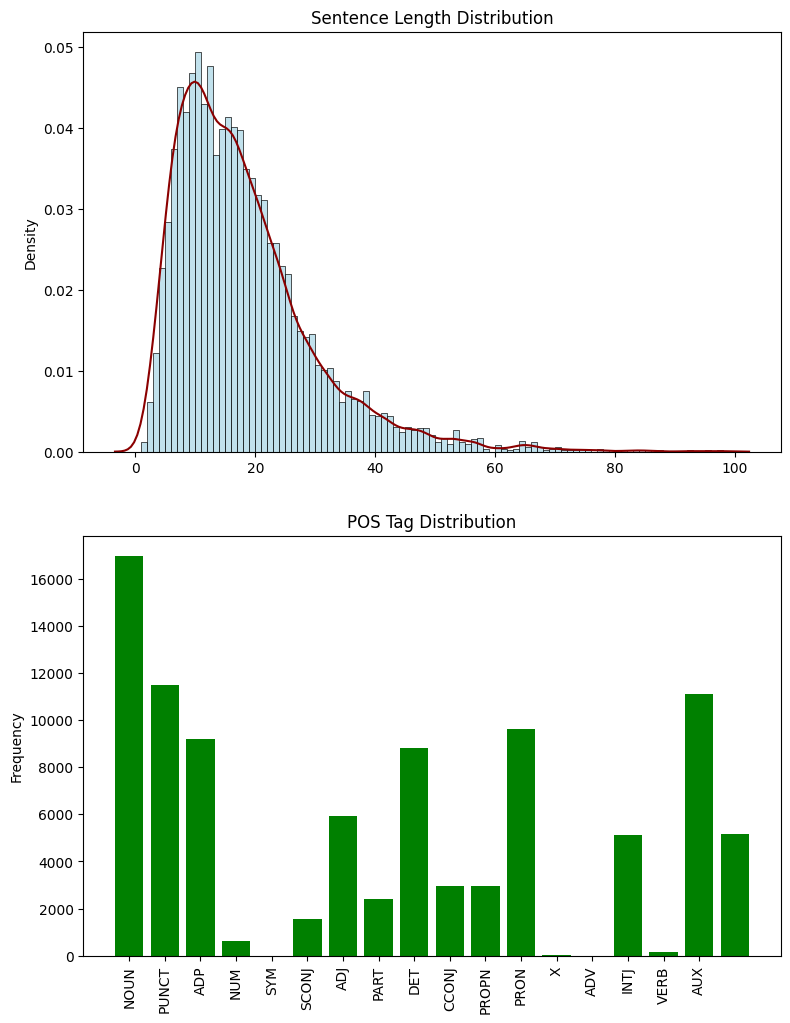

In [ ]:
def print_dataset_statistics(frequency_dict):
  # Load the dataset
  tokens = train_dataset['tokens'] + dev_dataset['tokens'] + test_dataset['tokens']

  fig, axs = plt.subplots(2,1,figsize = (9,12))

  count_list = [0 for i in range(18)]

  for i in train_dataset:
    for j,k in zip(i['upos'], i['tokens']):
      count_list[j] += 1
      frequency_dict[k] = frequency_dict.get(k, 0) + 1



  for i in dev_dataset:
    for j,k in zip(i['upos'], i['tokens']):
      count_list[j] += 1
      frequency_dict[k] = frequency_dict.get(k, 0) + 1

  for i in test_dataset:
    for j,k in zip(i['upos'], i['tokens']):
      count_list[j] += 1
      frequency_dict[k] = frequency_dict.get(k, 0) + 1

  map = {0: 'NOUN',
         1: 'PUNCT',
         2: 'ADP',
        3: 'NUM',
        4: 'SYM',
        5: 'SCONJ',
        6: 'ADJ',
        7: 'PART',
        8: 'DET',
        9: 'CCONJ',
        10: 'PROPN',
        11: 'PRON',
        12: 'X',
        14: 'ADV',
        15: 'INTJ',
        16: 'VERB',
        17: 'AUX'
}



  count_list[12] += count_list.pop(13)

  axs[1].bar(map.keys(), count_list, color='green')
  axs[1].set_xticks(range(len(count_list)))
  axs[1].set_xticklabels(map.values(),rotation = 90)
  axs[1].set_ylabel("Frequency")
  axs[1].set_title("POS Tag Distribution")


  # Calculate sentence lengths
  sentence_lengths = [len(sentence) for sentence in tokens]

  # Report the useful information
  num_sentences = len(tokens)
  total_tokens = sum(sentence_lengths)
  average_tokens = total_tokens / num_sentences
  min_tokens = min(sentence_lengths)
  max_tokens = max(sentence_lengths)

  # Sentence Length Distribution
  length_count = {}
  for length in sentence_lengths:
      length_count[length] = length_count.get(length, 0) + 1

  # Report the summary statistics
  print("Treebank Information:")
  print("----------------------")
  print("Total number of sentences:", num_sentences)
  print("Total number of tokens:", total_tokens)
  print("Average tokens per sentence:", average_tokens)
  print("Min tokens per sentence:", min_tokens)
  print("Max tokens per sentence:", max_tokens)
  print("------------------------------")
  print("Dataset keys:", train_dataset[0].keys())

  # Plotting the distribution
  lengths = sorted(length_count.keys())
  frequency = [length_count[length] for length in lengths]
  sns.histplot(sentence_lengths,stat = 'density', bins=max(sentence_lengths)-min(sentence_lengths), color='lightblue', ax=axs[0])
  sns.kdeplot(sentence_lengths, color='darkred', ax=axs[0], bw_adjust = 0.7)
  axs[0].set_ylabel("Density")
  axs[0].set_title("Sentence Length Distribution")


  fig.show()

frequency_dict = {}
print_dataset_statistics(frequency_dict)
print(len(frequency_dict))

SUMMARY

* Total number of sentences: 5243
* Total number of tokens: 94217
* Average tokens per sentence: 17.97
* Minimum tokens per sentence: 1
* Maximum tokens per sentence: 98

In [ ]:
#the function check if a tree is projective

def is_projective(tree):
  for i in range(len(tree)):
    if tree[i] == -1:
      continue
    left = min(i, tree[i])
    right = max(i, tree[i])

    for j in range(0, left):
      if tree[j] > left and tree[j] < right:
        return False
    for j in range(left+1, right):
      if tree[j] < left or tree[j] > right:
        return False
    for j in range(right+1, len(tree)):
      if tree[j] > left and tree[j] < right:
        return False

  return True

# the function creates a dictionary of word/index pairs: our embeddings vocabulary
# threshold is the minimum number of appearance for a token to be included in the embedding list
def create_dict(dataset, threshold=3):
  dic = {}  # dictionary of word counts
  for sample in dataset:
    for word in sample['tokens']:
      if word in dic:
        dic[word] += 1
      else:
        dic[word] = 1

  map = {}  # dictionary of word/index pairs. This is our embedding list
  map["<pad>"] = 0
  map["<ROOT>"] = 1
  map["<unk>"] = 2 #used for words that do not appear in our list

  next_indx = 3
  for word in dic.keys():
    if dic[word] >= threshold:
      map[word] = next_indx
      next_indx += 1

  return map


## Herdan/Heaps Law

In [ ]:
N = len(sum(train_dataset['tokens'], []) + sum(dev_dataset['tokens'], []) + sum(test_dataset['tokens'], []))
k = 32
Beta = 0.51

Heaps = k*N**Beta
print('Heaps law approximation:', int(Heaps), '\n'+'N = '+str(N)+'\n'+'|V| =', len(frequency_dict))

Heaps law approximation: 11014 
N = 94217
|V| = 11096


According to Herdan/Heaps Law, in very large corpora the relation between the number of tokens $N$ and the cardinality of the vocabulary $|V|$ is expressed as $$|V| = kN^{\beta}$$

where $k \in \mathbb{[10,100]}$ and $\beta \in \mathbb{[0.4, 0.75]}$.
In this case, considering the full dataset:


* $N = 94217$
* $|V| = 11096$


so, we can see that setting $k =  32$ and $\beta = 0.51$ we obtain

> $32\times 94217^{0.51} = 11014 \approx |V| = 11096$

## Zipf/Mandelbrot Law

Zipf/Mandelbrot Law state that, for web-scale dataset, the frequency $f(w_i)$ of the $n\text{-}th$ most frequent token scale like

$$f(w_i) = \frac{1}{(r+\beta)^{\alpha}}$$

with $\alpha\approx1$ and $\beta\approx2.7$

In [ ]:
alfa =1
Beta = 2.7

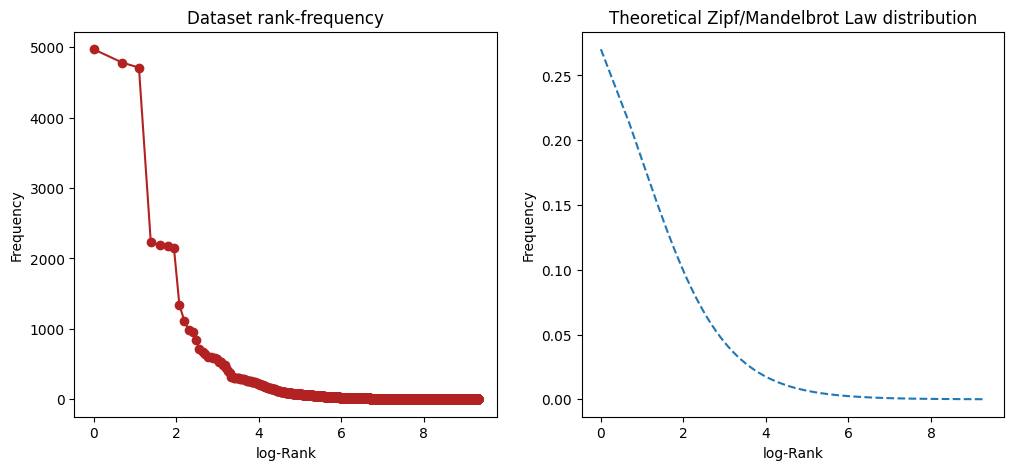

In [ ]:
#plotting Zipf/Mandelbrot Law

values = sorted(list(frequency_dict.values()),reverse = True)
rank = list(range(1,len(values)+1))
frequency = 1/(np.array(rank)+Beta)**alfa


#plot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12, 5))  # optional, to adjust the size of the figure
ax1.plot(np.log(rank), values, marker = 'o', linestyle = '-',color = 'firebrick')
ax1.set_xlabel('log-Rank')
ax1.set_ylabel('Frequency')
ax1.set_title('Dataset rank-frequency')

ax2.plot(np.log(rank), frequency, linestyle = '--' )
ax2.set_xlabel('log-Rank')
ax2.set_ylabel('Frequency')
ax2.set_title('Theoretical Zipf/Mandelbrot Law distribution')



plt.show()

## Data Cleaning and Projectivity Analysis

An arc from head to dependent is said to be `projective` if there is a path from the head to every word that lies between the head and the dependent, i.e. none of the arcs are crossing.
A tree  is said to be projective
 if all its arcs are projective.

 The Arc-eager presented here is for projective parsing, so non-projective trees from the training set will be removed. Nonetheless Test and Evaluation set will be left unchanged and the performance of the models when facing on non-projective trees will be analyzed later in the notebook.

\

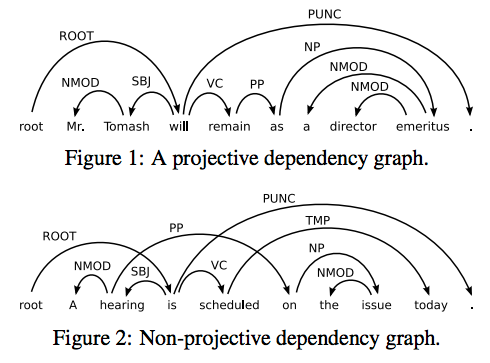




In [ ]:
# some dataset contains None values. This is not the case for this dataset, but i kept the function because it makes the code more general
def clean_None(example):
    indices_to_keep = [k for k, j in enumerate(example['head']) if j != 'None']
    example['head'] = [j for k, j in enumerate(example['head']) if k in indices_to_keep]
    example['tokens'] = [j for k, j in enumerate(example['tokens']) if k in indices_to_keep]
    return example


In [ ]:
full_train_len =len(train_dataset)

train_dataset = train_dataset.map(clean_None)
dev_dataset = dev_dataset.map(clean_None)
test_dataset = test_dataset.map(clean_None)

# remove non-projective sentences: heads in the gold tree are strings, we convert them to int
train_dataset = [sample for sample in train_dataset if is_projective([-1] + [int(head) for head in sample["head"]])]
dev_dataset = [sample for sample in dev_dataset]
test_dataset = [sample for sample in test_dataset]
# create the embedding dictionary

dev_proj_len = len([sample for sample in dev_dataset if is_projective([-1] + [int(head) for head in sample["head"]])])
test_proj_len = len([sample for sample in test_dataset if is_projective([-1] + [int(head) for head in sample["head"]])])

emb_dictionary = create_dict(train_dataset)

Map:   0%|          | 0/3176 [00:00<?, ? examples/s]

Map:   0%|          | 0/1032 [00:00<?, ? examples/s]

Map:   0%|          | 0/1035 [00:00<?, ? examples/s]

Number of samples:
Train:	 2922
Dev:	 1032
Test:	 1035

Number of non-projective trees in training set:	 254



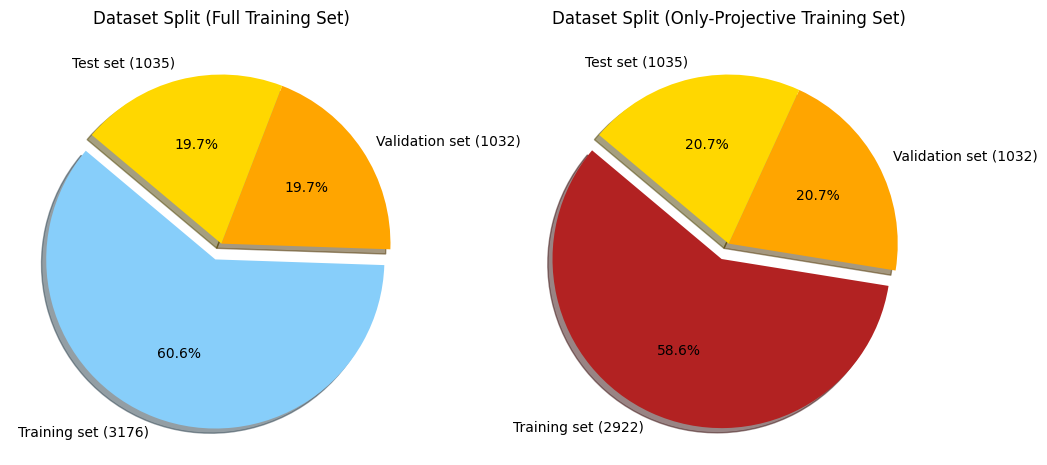

In [ ]:
print("Number of samples:")
print("Train:\t", len(train_dataset)) #(train_dataset is already free of non-projective trees)
print("Dev:\t", len(dev_dataset))
print("Test:\t", len(test_dataset))
print('\nNumber of non-projective trees in training set:\t', full_train_len-len(train_dataset), end = '\n\n')

projective_length = len(train_dataset)
sizes = [full_train_len, len(dev_dataset), len(test_dataset)]

fig, axs = plt.subplots(1,2, figsize = (12,7))


colors = ['lightskyblue','orange','gold']
explodes = (0.1, 0, 0)
labels_full = 'Training set ({})'.format(sizes[0]), 'Validation set ({})'.format(sizes[1]), 'Test set ({})'.format(sizes[2])
labels_projective = 'Training set ({})'.format(projective_length), 'Validation set ({})'.format(sizes[1]), 'Test set ({})'.format(sizes[2])

axs[0].pie(sizes, explode = explodes, labels = labels_full, colors = colors, autopct='%1.1f%%', shadow=True, startangle=140)
axs[0].set_title('Dataset Split (Full Training Set)')

colors = ['firebrick','orange','gold']
axs[1].pie([projective_length, sizes[1], sizes[2]], explode = explodes, labels = labels_projective, colors = colors, autopct='%1.1f%%', shadow=True, startangle=140)
axs[1].set_title('Dataset Split (Only-Projective Training Set)')

fig.show()

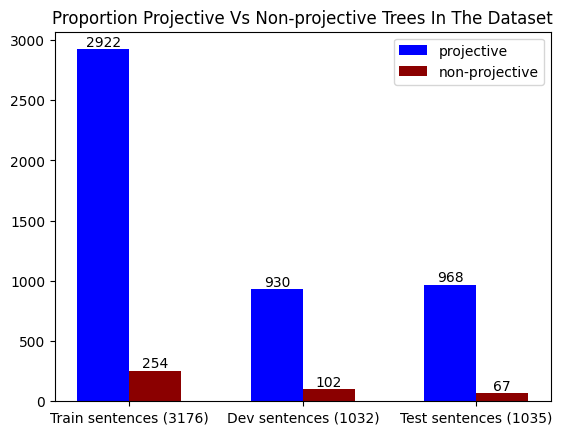

In [ ]:
#barplot of projective and non projective trees

len_train_datasets = [full_train_len, len(dev_dataset), len(test_dataset)]
projective_length = [len(train_dataset), dev_proj_len, test_proj_len]
non_projective_length = [total - proj for total, proj in zip(len_train_datasets, projective_length)]

bar_width = 0.3
labels = ['Train sentences ({})'.format(full_train_len),'Dev sentences ({})'.format(len(dev_dataset)),'Test sentences ({})'.format(len(test_dataset))]

values_proj = [0,1,2]
values_non_proj = [0.3,1.3,2.3]

plt.bar(values_proj, projective_length, width=bar_width, color='blue', label='projective')
plt.bar(values_non_proj, non_projective_length, width=bar_width, color='darkred', label='non-projective')


for i, val in enumerate(projective_length):
    plt.text(values_proj[i], val, str(val), ha='center', va='bottom')
for i, val in enumerate(non_projective_length):
    plt.text(values_non_proj[i], val, str(val), ha='center', va='bottom')

plt.xticks([0.15, 1.15, 2.15], labels)

plt.title('Proportion Projective Vs Non-projective Trees In The Dataset')
plt.legend(loc='best')
plt.show()

In [ ]:
# look the first n example and check the accuracy of oracle and arc_eager

def safety_check(n = 2000):
  count=0
  for i in range(n):
    sentence, gold = train_dataset[i]["tokens"],[int(i) for i in train_dataset[i]["head"]]
    sentence = ["<ROOT>"]+ sentence
    gold = [-1] + gold

    parser = ArcEager(sentence)
    oracle = Oracle(parser, gold)

    while not parser.is_tree_final():
      if oracle.is_left_arc_gold():
        parser.left_arc()
      elif oracle.is_right_arc_gold():
        parser.right_arc()
      elif oracle.is_reduce():
        parser.reduce()
      elif oracle.is_shift_gold():
        parser.shift()


    if(parser.arcs != gold):
      count+=1
      print(sentence)
      print(parser.arcs)
      print(gold)
  return "success" if count == 0 else "error"



safety_check()

'success'

In [ ]:
def process_sample(sample, get_gold_path = False, BERT = False):

  # put sentence and gold tree in our format
  sentence = ["<ROOT>"] + sample["tokens"]
  gold = [-1] + [int(i) for i in sample["head"]]  #heads in the gold tree are strings, we convert them to int

  # embedding ids of sentence words
  enc_sentence = [emb_dictionary[word] if word in emb_dictionary else emb_dictionary["<unk>"] for word in sentence]

  # gold_path and gold_moves are parallel arrays whose elements refer to parsing steps
  gold_path = []   # record two topmost stack tokens and first buffer token for current step
  gold_moves = []  # contains oracle (canonical) move for current step: 0 is left, 1 right, 2 reduce, 3 shift

  if get_gold_path:  # only for training
    parser = ArcEager(sentence)
    oracle = Oracle(parser, gold)

    while not parser.is_tree_final():
      # save configuration
      if len(parser.stack) <= 1:
        configuration = [-1, parser.stack[len(parser.stack)-1]]
      else:
        configuration = [parser.stack[len(parser.stack)-2], parser.stack[len(parser.stack)-1]]
      if len(parser.buffer) == 0:
        configuration.append(-1)
      else:
        configuration.append(parser.buffer[0])
      gold_path.append(configuration)

      # save gold move
      if oracle.is_left_arc_gold():
        gold_moves.append(0)
        parser.left_arc()
      elif oracle.is_right_arc_gold():
        parser.right_arc()
        gold_moves.append(1)
      elif oracle.is_reduce():
        parser.reduce()
        gold_moves.append(2)
      elif oracle.is_shift_gold():
        parser.shift()
        gold_moves.append(3)


  if BERT:

    sentence = ['ROOT'] + sample["tokens"]

    return enc_sentence, gold_path, gold_moves, gold, sentence # also includes sentences tokens

  return enc_sentence, gold_path, gold_moves, gold

In [ ]:
def prepare_batch(batch_data, get_gold_path=False, BERT = False):
  data = [process_sample(s, get_gold_path=get_gold_path, BERT = BERT) for s in batch_data]
  # sentences, paths, moves, trees are parallel arrays, each element refers to a sentence
  sentences = [s[0] for s in data]
  paths = [s[1] for s in data]
  moves = [s[2] for s in data]
  trees = [s[3] for s in data]

  if BERT:

    full_sent = [s[4] for s in data]

    return sentences, paths, moves, trees, full_sent #also includes sentences tokens

  return sentences, paths, moves, trees

# Loss and Training-Test Loop Definition

## Multimargin Hinge Loss

To train the BiLSTM and BERT i used both CELoss and hinge loss, a margin-based objective function aimed at maximize the margin between
* the higest scoring correct action
* the highest scoring incorrect action

Let $A$ be the set of all possible transitions and $G$ the set of gold transitions at current step. The hinge loss is defined as:

$$\max(0, 1-\max_{op\text{ }\in\text{ }\ G}\text{ Score}(\phi(c), op)\text{ }+ \max_{op'\in A\setminus G}\text{Score}(\phi(c), op'))$$


For arc-eager oracle, $|G|$ = $1$. So here, we maximize the margin between the correct transition and the transition with highest score between the incorrect ones.

In [ ]:
class HingeLoss(torch.nn.Module): #multimargin hinge loss
    def _init_(self):
        super(HingeLoss, self)._init_()

    def forward(self, predictions, op):
        predictions.to(device)

        filtered = predictions.clone()
        filtered[torch.arange(len(op)).to(device),op] = -float('inf')
        loss =  torch.ones(len(op)).to(device) - predictions[torch.arange(len(op)).to(device),op] + torch.max(filtered, dim=-1)[0].to(device)
        loss = torch.maximum(loss.to(device), torch.zeros(loss.shape).to(device))

        return (1/len(op)) * torch.sum(loss)

## Train and Test Functions

In [ ]:
def train(model, dataloader, criterion, optimizer, BERT):
  model.train()
  total_loss = 0
  count = 0

  for batch in dataloader:
    optimizer.zero_grad()
    if BERT:

      sentences, paths, moves, trees,full_sent = batch
      out = model(full_sent, paths)

    else:

      sentences, paths, moves, trees = batch
      out = model(sentences, paths)

    labels = torch.tensor(sum(moves, [])).to(device)
    loss = criterion(out, labels)

    count +=1
    total_loss += loss.item()

    loss.backward()
    optimizer.step()

  return total_loss/count

def test(model, dataloader, BERT):
  model.eval()

  gold = []
  preds = []

  for batch in dataloader:

    if BERT:

      sentences, paths, moves, trees, full_sent = batch

      with torch.no_grad():
        pred, pred_moves = model.infere(sentences, full_sent) #return predicted trees and moves(i.e. transition), in this function only pred is used


    else:

      sentences, paths, moves, trees = batch

      with torch.no_grad():
        pred, pred_moves = model.infere(sentences) #return the predicted trees and moves, in this function only pred is used

    gold += trees
    preds += pred

  return evaluate(gold, preds)

In [ ]:
def evaluate(gold, preds):
  total = 0
  correct = 0

  for g, p in zip(gold, preds):
    for i in range(1,len(g)):
      total += 1
      if g[i] == p[i]:
        correct += 1

  return correct/total

# BiLSTM Model

This model is composed by a `BiLSTM` and a `Multilayer Perceptron` (MLP).

The BiLSTM is a netwrok composed of two LSTM layers operating in opposite directions: one to capture the context to the left of each token and one to capture the context at the right, indipendently. The outputs of both left and the right hidden states are then concatenated to compute the output correspondent to each input.

In this case, the BiLSTM output a vector, one for each token, that represent the `contextual embedding`.
The embeddings are then fed into `MLP`, according to some specific feature function, to perform the classification task. I experimented with different function of features, included the concatenation of &nbsp; $\text{ }(\sigma_1,\beta_1)$, &nbsp; but the most effective solution i found was to use &nbsp; $\text{ }(\sigma_{last},\sigma_{second-to-last},\beta_1)\text{ }$.

\

Here $\text{ }\sigma_i\in\Sigma\text{ }$, &nbsp; $\beta_i \in B$ &nbsp; and $i$ is the associated index.

At inference time, the move with the highest score is selected if it meet specific conditions. Otherwise, the second highest score is selected.

In [ ]:
class Net(nn.Module):

  def __init__(self, device):
    super(Net, self).__init__()

    functions = {'Tanh': torch.nn.Tanh(), 'Sigmoid': torch.nn.Sigmoid(), 'Leaky_Relu': torch.nn.LeakyReLU(), 'Relu': torch.nn.ReLU()} #dictionary used to select activation
    self.device = device
    self.embeddings = nn.Embedding(len(emb_dictionary), EMBEDDING_SIZE, padding_idx=emb_dictionary["<pad>"])

    # initialize bi-LSTM
    self.lstm = nn.LSTM(EMBEDDING_SIZE, LSTM_SIZE, num_layers = LSTM_LAYERS, bidirectional=True, dropout=DROPOUT)

    # initialize feedforward

    self.w1 = torch.nn.Linear(6*LSTM_SIZE, MLP_SIZE, bias=True)
    self.activation = functions[activation] #select the function from dictionary
    self.w2 = torch.nn.Linear(MLP_SIZE, 4, bias=True)
    self.softmax = torch.nn.Softmax(dim=-1)

    self.dropout = torch.nn.Dropout(DROPOUT)


  def forward(self, x, paths):
    # get the embeddings
    x = [self.dropout(self.embeddings(torch.tensor(i).to(self.device))) for i in x]

    # run the bi-lstm
    h = self.lstm_pass(x)

    # for each parser configuration that we need to score we arrange from the
    # output of the bi-lstm the correct input for the feedforward
    mlp_input = self.get_mlp_input(paths, h)

    # run the feedforward and get the scores for each possible action
    out = self.mlp(mlp_input)

    return out

  def lstm_pass(self, x):
    x = torch.nn.utils.rnn.pack_sequence(x, enforce_sorted=False)
    h, (h_0, c_0) = self.lstm(x)
    h, h_sizes = torch.nn.utils.rnn.pad_packed_sequence(h) # size h: (length_sentences, batch, output_hidden_units)
    return h

  def get_mlp_input(self, configurations, h):
    mlp_input = []
    zero_tensor = torch.zeros(2*LSTM_SIZE, requires_grad=False).to(self.device)
    for i in range(len(configurations)): # for every sentence in the batch
      for j in configurations[i]: # for each configuration of a sentence
        mlp_input.append(torch.cat([zero_tensor if j[0]==-1 else h[j[0]][i], zero_tensor if j[1]==-1 else h[j[1]][i], zero_tensor if j[2]==-1 else h[j[2]][i]]))
    mlp_input = torch.stack(mlp_input).to(self.device)
    return mlp_input

  def mlp(self, x):
    return self.w2(self.dropout(self.activation(self.w1(self.dropout(x)))))

  # we use this function at inference time. We run the parser and at each step
  # we pick as next move the one with the highest score assigned by the model
  def infere(self, x):

    parsers = [ArcEager(i) for i in x]

    x = [self.embeddings(torch.tensor(i).to(self.device)) for i in x]

    h = self.lstm_pass(x)
    pred_moves = [[] for i in parsers]

    while not self.parsed_all(parsers):
      # get the current configuration and score next moves
      configurations = self.get_configurations(parsers)
      mlp_input = self.get_mlp_input(configurations, h)
      mlp_out = self.mlp(mlp_input)
      # take the next parsing step
      pred_moves = self.parse_step(parsers, mlp_out, pred_moves)

    # return the predicted dependency tree
    return [parser.arcs for parser in parsers], pred_moves

  def get_configurations(self, parsers):
    configurations = []

    for parser in parsers:
      if parser.is_tree_final():
        conf = [-1, -1, -1]
      else:

        if len(parser.stack) <= 1:
          conf = [-1, parser.stack[len(parser.stack)-1]]
        else:
          conf = [parser.stack[len(parser.stack)-2], parser.stack[len(parser.stack)-1]]

        if len(parser.buffer) == 0:
          conf.append(-1)
        else:
          conf.append(parser.buffer[0])
      configurations.append([conf])

    return configurations


  def parsed_all(self, parsers):
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True


  def parse_step(self, parsers, moves, pred_moves):
    moves_argm = moves.argmax(-1)
    for i in range(len(parsers)):
      if parsers[i].is_tree_final():
        continue

      else:
        transition_op = moves[i]
        ## left_arc ##
        if moves_argm[i] == 0:

          if parsers[i].stack[-1] != 0 and parsers[i].arcs[parsers[i].stack[-1]] == -1:

            parsers[i].left_arc()
            pred_moves[i].append(0)
          # if not left arc

          elif parsers[i].stack[-1] == 0: # if the last element of the stack is the ROOT

          #cannot apply reduce

            if transition_op[3] > transition_op[1]:
              parsers[i].shift()
              pred_moves[i].append(3)
            else:
              parsers[i].right_arc()
              pred_moves[i].append(1)

          else:

            if transition_op[1] > transition_op[2] and transition_op[1] > transition_op[3]:
              parsers[i].right_arc()
              pred_moves[i].append(1)
            elif transition_op[2] > transition_op[3]:
              parsers[i].reduce()
              pred_moves[i].append(2)
            else:
              parsers[i].shift()
              pred_moves[i].append(3)


        ## right_arc ##
        elif moves_argm[i] == 1:

            parsers[i].right_arc()
            pred_moves[i].append(1)

        ## reduce ##
        elif moves_argm[i] == 2:

            if parsers[i].arcs[parsers[i].stack[-1]] != -1:

              parsers[i].reduce()
              pred_moves[i].append(2)

            # the last element is not dependent of any word
            elif transition_op[0] > transition_op[1] and transition_op[0] > transition_op[3]:
              if parsers[i].stack[-1] != 0 and parsers[i].arcs[parsers[i].stack[-1]] == -1:
                if transition_op[1] > transition_op[3]:
                  parsers[i].right_arc()
                  pred_moves[i].append(1)
                else:
                  parsers[i].shift()
                  pred_moves[i].append(3)

              else:
                pred_moves[i].append(0)

            elif transition_op[1] > transition_op[3]:
              parsers[i].right_arc()
              pred_moves[i].append(1)


            else:
              parsers[i].shift()
              pred_moves[i].append(3)


        ## shift ##
        elif moves_argm[i] == 3:

            parsers[i].shift()
            pred_moves[i].append(3)
    return pred_moves

In [ ]:
wandb.init(
    project="NLP_dependecy_parsing",

    config={
    "learning_rate": 0.005,
    "NeuralParser": "BiLSTM",
    "epochs": 7,
    "DROPOUT" : 0.3,
    "act_function": 'Leaky_Relu',
    "BATCH_SIZE": 32,
    'criterion': 'HingeLoss',
    'EMBEDDING_SIZE': 200
    }
)

config = wandb.config #used in next cell to provide hyperparameters to respective variables

wandb: Currently logged in as: cesare-bidini (tema_name_unk). Use `wandb login --relogin` to force relogin


In [ ]:
EMBEDDING_SIZE = config.EMBEDDING_SIZE
LSTM_SIZE = 200
LSTM_LAYERS = 2
MLP_SIZE = 200
DROPOUT = config.DROPOUT
EPOCHS = config.epochs
LR = config.learning_rate
activation = config.act_function

In [ ]:
BATCH_SIZE = config.BATCH_SIZE

BERT = False

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=partial(prepare_batch, get_gold_path=True, BERT = BERT))
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch, BERT = BERT))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch, get_gold_path = True, BERT = BERT))

## Training and Testing

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model = Net(device)
model.to(device)

criterion = HingeLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print('hyperparameters:',model.activation,'| lr:', LR,'| DO:', DROPOUT, end= '\n')

for epoch in range(EPOCHS):
  avg_train_loss = train(model, train_dataloader, criterion, optimizer, BERT = False)
  val_uas = test(model, dev_dataloader, BERT = False)
  wandb.log({"avg_train_loss": avg_train_loss, "val_uas": val_uas})


  print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format( epoch, avg_train_loss, val_uas))

Device: cuda
hyperparameters: LeakyReLU(negative_slope=0.01) | lr: 0.005 | DO: 0.3
Epoch:   0 | avg_train_loss: 0.562 | dev_uas: 0.654 |
Epoch:   1 | avg_train_loss: 0.316 | dev_uas: 0.699 |
Epoch:   2 | avg_train_loss: 0.253 | dev_uas: 0.737 |
Epoch:   3 | avg_train_loss: 0.214 | dev_uas: 0.750 |
Epoch:   4 | avg_train_loss: 0.186 | dev_uas: 0.760 |
Epoch:   5 | avg_train_loss: 0.170 | dev_uas: 0.762 |
Epoch:   6 | avg_train_loss: 0.155 | dev_uas: 0.770 |


In [ ]:
test_uas = test(model, test_dataloader, BERT = False)
print("test_uas: {:5.3f}".format( test_uas))

wandb.log({"test_uas": test_uas})

test_uas: 0.772


In [ ]:
wandb.finish()

avg_train_loss,█▄▃▂▂▁▁
test_uas,▁
val_uas,▁▄▆▇▇██
avg_train_loss,0.15531
test_uas,0.77228
val_uas,0.7699


# BERT Model

`BERT`(Bidirectional Encoder Representation from Transformer) is a model that take tokens as inputs and produce context embeddings looking jointly at left and right context. The model is representend by the encoder part of a transformed and is pre-trained on `mask language model task`(MLM) and on next `sentence prediction task`(NSP).

\

In this model `bert-base-multilingual-uncased` is used and the 3 layers predecing the last layer are fine-tuned. The output embeddings of the `4 layer preceding the final one` (the 3 fine-tuned layers and the one preceding them) are then averaged to obtain the final representations that will be fed to the MLP.


As a note, it is worth noting that, in this case, fine-tune and average the last n-layers before the last hidden layer of bert works better than including also the last hidden layer.

\

Unlike the previously used BiLSTM, BERT take as input subword tokens (obtained from a modified version of Byte Pair Encoding called WordPiece). Because of this, are  needed additional functions to keep track of the indices of tokens. In this respect, i used the `word_ids` attribute of the tokenizer and developed a function to group together the tokens derived from the same word. The tokens are then averaged to obtain an embedding representation of each words. Furthermore the  

After this process, the rest of the model is the same as the BiLSTM one.

In [ ]:
class BERTNet(Net):

  def __init__(self, device):

    super(BERTNet,self).__init__(device)

    self.w1 = torch.nn.Linear(BERT_OUT*3, MLP_SIZE, bias=True)
    functions = {'Tanh': torch.nn.Tanh(), 'Sigmoid': torch.nn.Sigmoid(), 'Leaky_Relu': torch.nn.LeakyReLU(), 'Relu': torch.nn.ReLU()} # activations dictionary
    self.activation = functions[activation] #retrieve activation from dictionary
    self.w2 = torch.nn.Linear(MLP_SIZE, 4, bias=True)
    self.softmax = torch.nn.Softmax(dim=-1)
    self.device = device

    self.bert = AutoModel.from_pretrained('bert-base-multilingual-uncased')
    self.tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-uncased')

    self.freeze_bert_layers(self.bert, fine_tuned_layers)#call the method to unfreeze the layers that will be fine tuned



  def token_aligner(self,single_sent):# function to obtain the word_ids that return the list of indeces of the word that originated tokens


      sent = self.tokenizer(single_sent, add_special_tokens = False,return_tensors='pt',is_split_into_words = True)# tokenize the sentence creating the input for bert, is the only method that return word_ids

      subwords = []

      for i in range(len(sent['input_ids'][0])): #this for cycle is to group all takes that originates from the same word together

        where = np.where(np.array(sent.word_ids()) == i)[0] #create a boolean mask that selects, for each original word, the indeces of the tokens

        subwords.append(where)

      return subwords


  # for this sentence for example ['a tokenizer b'] , this is what word_ids() method returns: [0, 1, 1, 2], and this is what the function token_aligner returns: [array([0]), array([1, 2]), array([3]), array([], dtype=int64)]


  def freeze_bert_layers(self,bert, n_last_layers): #function for fine tuning

    num_layers = len(self.bert.encoder.layer)

    for param in self.bert.parameters():
        param.requires_grad = False

    for i in range(num_layers - n_last_layers-1, num_layers-1):
        for param in self.bert.encoder.layer[i].parameters():
            param.requires_grad = True



  def context_emb(self,batch):


    copy = batch[:]

    batch = self.tokenizer(batch, is_split_into_words=True, padding = True, add_special_tokens = False,return_tensors='pt').to(self.device) # obtain input for BERT from the batch



    emb = self.bert(**batch,  output_hidden_states=True) #BERT output



    hidden_states = emb.hidden_states
    cls_emb = torch.sum(torch.stack(hidden_states[-4:]), dim=0) / 4 # average of embeddings of the 4 layers preceding the last layer of BERT, as described


    aligned_ids = []

    for i in copy:
      temp = self.token_aligner(i) #retrieve word_ids for each sentence
      aligned_ids.append(temp) #list of word_ids


    size = cls_emb.size(1) #number of token for each sentence

    for j in range(cls_emb.size(0)):

      aligned = [cls_emb[j,i].to(self.device) for i in aligned_ids[j] if i.size>0 ] # grouping tokens embeddings

      aligned = [i.sum(dim = 0)/i.size(0) if i.dim() > 1 else i for i in aligned] #average the tokens originated from the same word


      conc = aligned + [torch.zeros(BERT_OUT).to(self.device) for k in range(size-len(aligned))] #restore the matrix dimension with padding


      cls_emb[j] = torch.stack(conc).to(self.device) # recreating the tensor with same dimension of the batch


    return cls_emb.permute(1,0,2).to(self.device)

  def forward(self,x, paths):

    h = self.context_emb(x).to(self.device)

    input = self.get_ffnn_input(paths, h)

    # run the feedforward and get the scores for each possible action
    out = self.ffnn_output(input).to(self.device)

    return out


  def get_ffnn_input(self, configurations, h):
    mlp_input = []
    zero_tensor = torch.zeros(BERT_OUT, requires_grad=False).to(self.device)
    for i in range(len(configurations)): # for every sentence in the batch
      for j in configurations[i]: # for each configuration of a sentence
        mlp_input.append(torch.cat([zero_tensor if j[0]==-1 else h[j[0]][i], zero_tensor if j[1]==-1 else h[j[1]][i], zero_tensor if j[2]==-1 else h[j[2]][i]]))
    mlp_input = torch.stack(mlp_input).to(self.device)
    return mlp_input

  def ffnn_output(self, x):
    return self.w2(self.dropout(self.activation(self.w1(self.dropout(x)))))

  # we use this function at inference time. We run the parser and at each step
  # we pick as next move the one with the highest score assigned by the model
  def infere(self, input_ids, x):

    parsers = [ArcEager(i) for i in input_ids]



    h = self.context_emb(x).to(self.device)
    pred_moves = [[] for i in range(len(parsers))]

    while not self.parsed_all(parsers):
      # get the current configuration and score next moves
      configurations = self.get_configurations(parsers)
      mlp_input = self.get_ffnn_input(configurations, h)
      mlp_out = self.ffnn_output(mlp_input).to(self.device)
      # take the next parsing step
      pred_moves = self.parse_step(parsers, mlp_out, pred_moves)

    # return the predicted dependency tree
    return [parser.arcs for parser in parsers], pred_moves

  def get_configurations(self, parsers):
    configurations = []

    for parser in parsers:
      if parser.is_tree_final():
        conf = [-1, -1, -1]
      else:

        if len(parser.stack) == 1:
          conf = [-1, parser.stack[len(parser.stack)-1]]
        else:
          conf = [parser.stack[len(parser.stack)-2], parser.stack[len(parser.stack)-1]]

        if len(parser.buffer) == 0:
          conf.append(-1)
        else:
          conf.append(parser.buffer[0])
      configurations.append([conf])

    return configurations


  def parsed_all(self, parsers):
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True

  # In this function we select and perform the next move according to the scores obtained.
  # We need to be careful and select correct moves, e.g. don't do a shift if the buffer
  # is empty or a left arc if σ2 is the ROOT. For clarity sake we didn't implement
  # these checks in the parser so we must do them here. This renders the function quite ugly
  def parse_step(self, parsers, moves, pred_moves):
    moves_argm = moves.argmax(-1)
    for i in range(len(parsers)):
      if parsers[i].is_tree_final():
        continue

      else:
        transition_op = moves[i]
        ## left_arc ##
        if moves_argm[i] == 0:

          if parsers[i].stack[-1] != 0 and parsers[i].arcs[parsers[i].stack[-1]] == -1:

            parsers[i].left_arc()
            pred_moves[i].append(0)
          # if preconditions aren't met

          elif parsers[i].stack[-1] == 0: # if the last element of the stack is the ROOT

            #cannot apply reduce

            if transition_op[3] > transition_op[1]:
              parsers[i].shift()
              pred_moves[i].append(3)
            else:
              parsers[i].right_arc()
              pred_moves[i].append(1)
          else: # the last element of the stack already has a head

            if transition_op[1] > transition_op[2] and transition_op[1] > transition_op[3]:
              parsers[i].right_arc()
              pred_moves[i].append(1)
            elif transition_op[2] > transition_op[3]:
              parsers[i].reduce()
              pred_moves[i].append(2)

            else:
              parsers[i].shift()
              pred_moves[i].append(3)


        ## right_arc ##
        elif moves_argm[i] == 1:

            parsers[i].right_arc()
            pred_moves[i].append(1)

        ## reduce ##
        elif moves_argm[i] == 2:

            if parsers[i].arcs[parsers[i].stack[-1]] != -1:

              parsers[i].reduce()
              pred_moves[i].append(2)
            # the last element is not dependent of any word
            elif transition_op[0] > transition_op[1] and transition_op[0] > transition_op[3]:
              if parsers[i].stack[-1] != 0  and parsers[i].arcs[parsers[i].stack[-1]] == -1:
                if transition_op[1] > transition_op[3]:
                  parsers[i].right_arc()
                  pred_moves[i].append(1)
                else:
                  parsers[i].shift()
                  pred_moves[i].append(3)

            elif transition_op[1] > transition_op[3]:
              parsers[i].right_arc()
              pred_moves[i].append(1)


            else:
              parsers[i].shift()
              pred_moves[i].append(3)


        ## shift ##
        elif moves_argm[i] == 3:

            parsers[i].shift()
            pred_moves[i].append(3)

    return pred_moves

In [ ]:
wandb.init(
    project="NLP_dependecy_parsing",

    config={
    "learning_rate": 0.0001,
    "NeuralParser": "BERT",
    "epochs": 6,
    "DROPOUT" : 0.3,
    "act_function": "Leaky_Relu",
    "BATCH_SIZE": 32,
    'criterion': 'HingeLoss',
    'n_tolast_layer_trained': 3,
    'MLP_SIZE': 200
    }
)

config_bert = wandb.config

In [ ]:
MLP_SIZE = config_bert.MLP_SIZE
DROPOUT = config_bert.DROPOUT
EPOCHS = config_bert.epochs
LR = config_bert.learning_rate# learning rate
fine_tuned_layers = config_bert.n_tolast_layer_trained
activation = config_bert.act_function

In [ ]:
BATCH_SIZE = config_bert.BATCH_SIZE


BERT_OUT = 768
BERT = True

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=partial(prepare_batch, get_gold_path=True, BERT = BERT))
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch, BERT = BERT))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch,get_gold_path = True, BERT= BERT))

## Training and Testing

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model_bert = BERTNet(device)
model_bert.to(device)

criterion = HingeLoss()
optimizer = torch.optim.Adam(model_bert.parameters(), lr=LR)

print('hyperparameters:',model_bert.activation,'|lr:', LR,'|DO: ', DROPOUT,'|fine-tuned layers:', fine_tuned_layers, end = '\n')

for epoch in range(EPOCHS):
  avg_train_loss = train(model_bert, train_dataloader, criterion, optimizer, BERT = True)
  val_uas = test(model_bert, dev_dataloader, BERT = True)
  wandb.log({"avg_train_loss": avg_train_loss, "val_uas": val_uas})

  print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format( epoch, avg_train_loss, val_uas))

Device: cuda
LeakyReLU(negative_slope=0.01)


Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


LeakyReLU(negative_slope=0.01)
Epoch:   0 | avg_train_loss: 0.505 | dev_uas: 0.781 |
Epoch:   1 | avg_train_loss: 0.239 | dev_uas: 0.840 |
Epoch:   2 | avg_train_loss: 0.189 | dev_uas: 0.862 |
Epoch:   3 | avg_train_loss: 0.160 | dev_uas: 0.874 |
Epoch:   4 | avg_train_loss: 0.142 | dev_uas: 0.884 |
Epoch:   5 | avg_train_loss: 0.130 | dev_uas: 0.881 |


In [ ]:
test_uas = test(model_bert, test_dataloader, BERT = True)
print("test_uas: {:5.3f}".format( test_uas))
wandb.log({"test_uas": test_uas})

test_uas: 0.886


In [ ]:
wandb.finish()

avg_train_loss,█▃▂▂▁▁
test_uas,▁
val_uas,▁▅▇▇██
avg_train_loss,0.12997
test_uas,0.88566
val_uas,0.88127


# Comparison Between Models

I did experiment with many different hyperparameters, but only the most relevants will be shown for clarity and brevity sake.

Regardless of the hyperparmeters choice, the model using BERT representations consistently outperforms the one using BiLSTM representations in test accuracy. Moreover the model tend to generalize better while the BiLSTM model tend to overfit.

The use of `Hinge Loss` enhances performance and guarantees a better generalization for almost every hyperparameters choice, compared to models that use Cross Entropy.

The difference between models with same architechture but different hyperparameters is of the order of some percentage points. Learning rate is one of the most impactful hyperparameters.

BERT model outperformed by far the BiLSTM displaying better results on UAS metric.

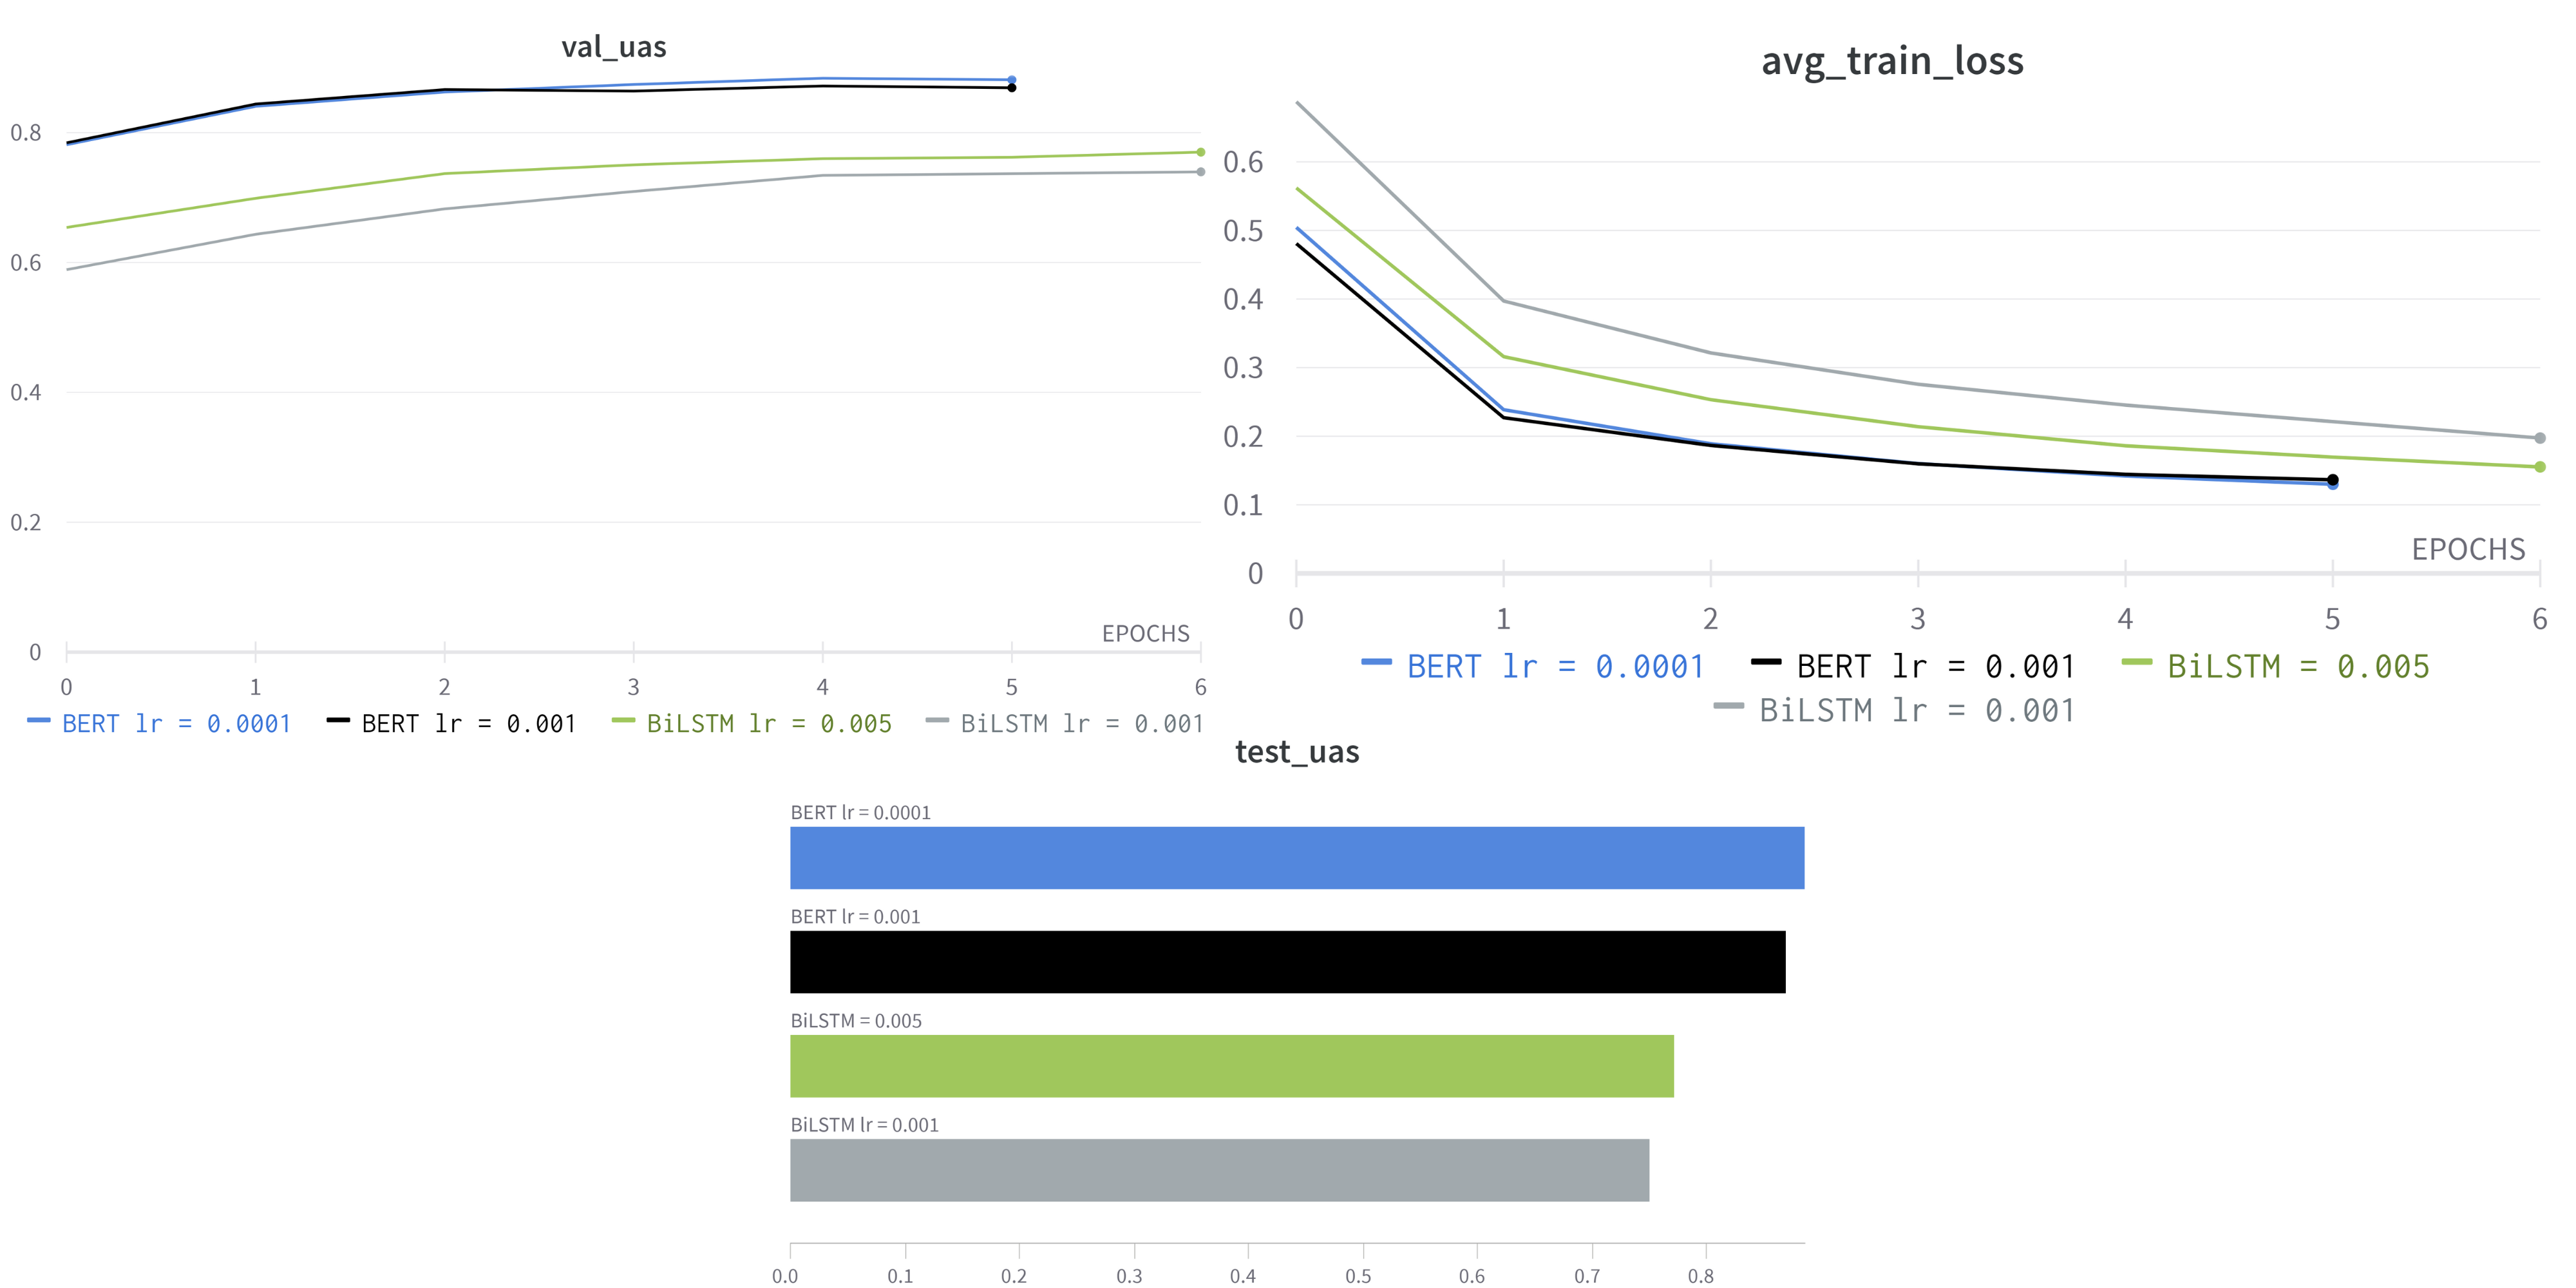
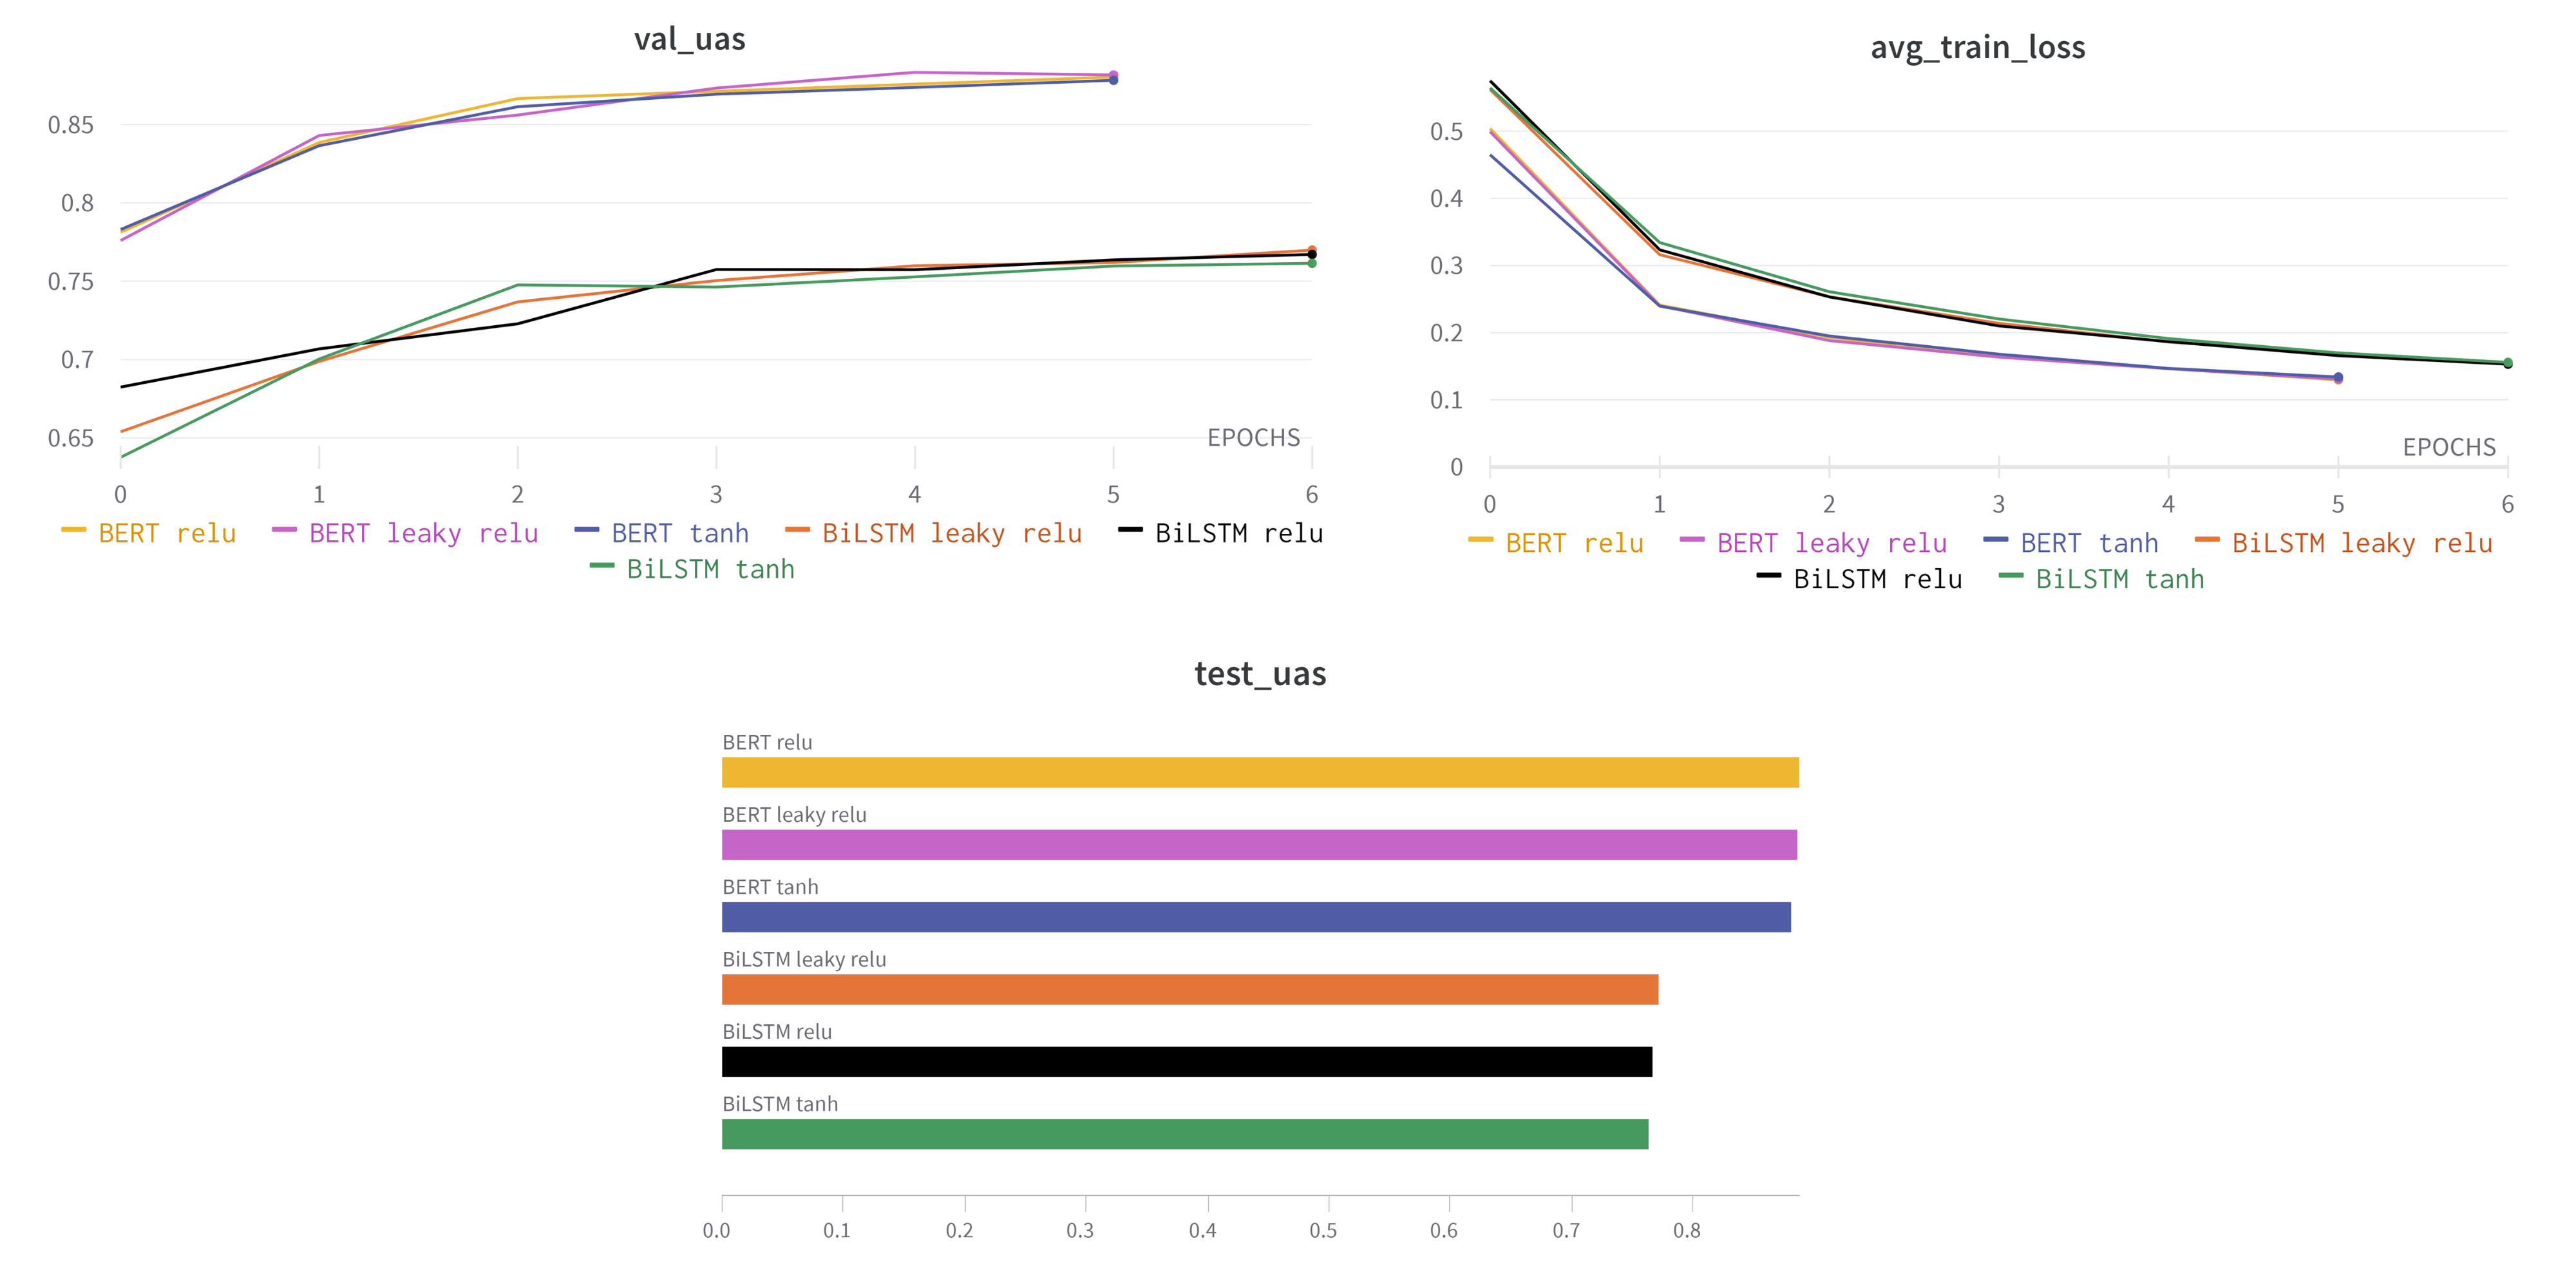
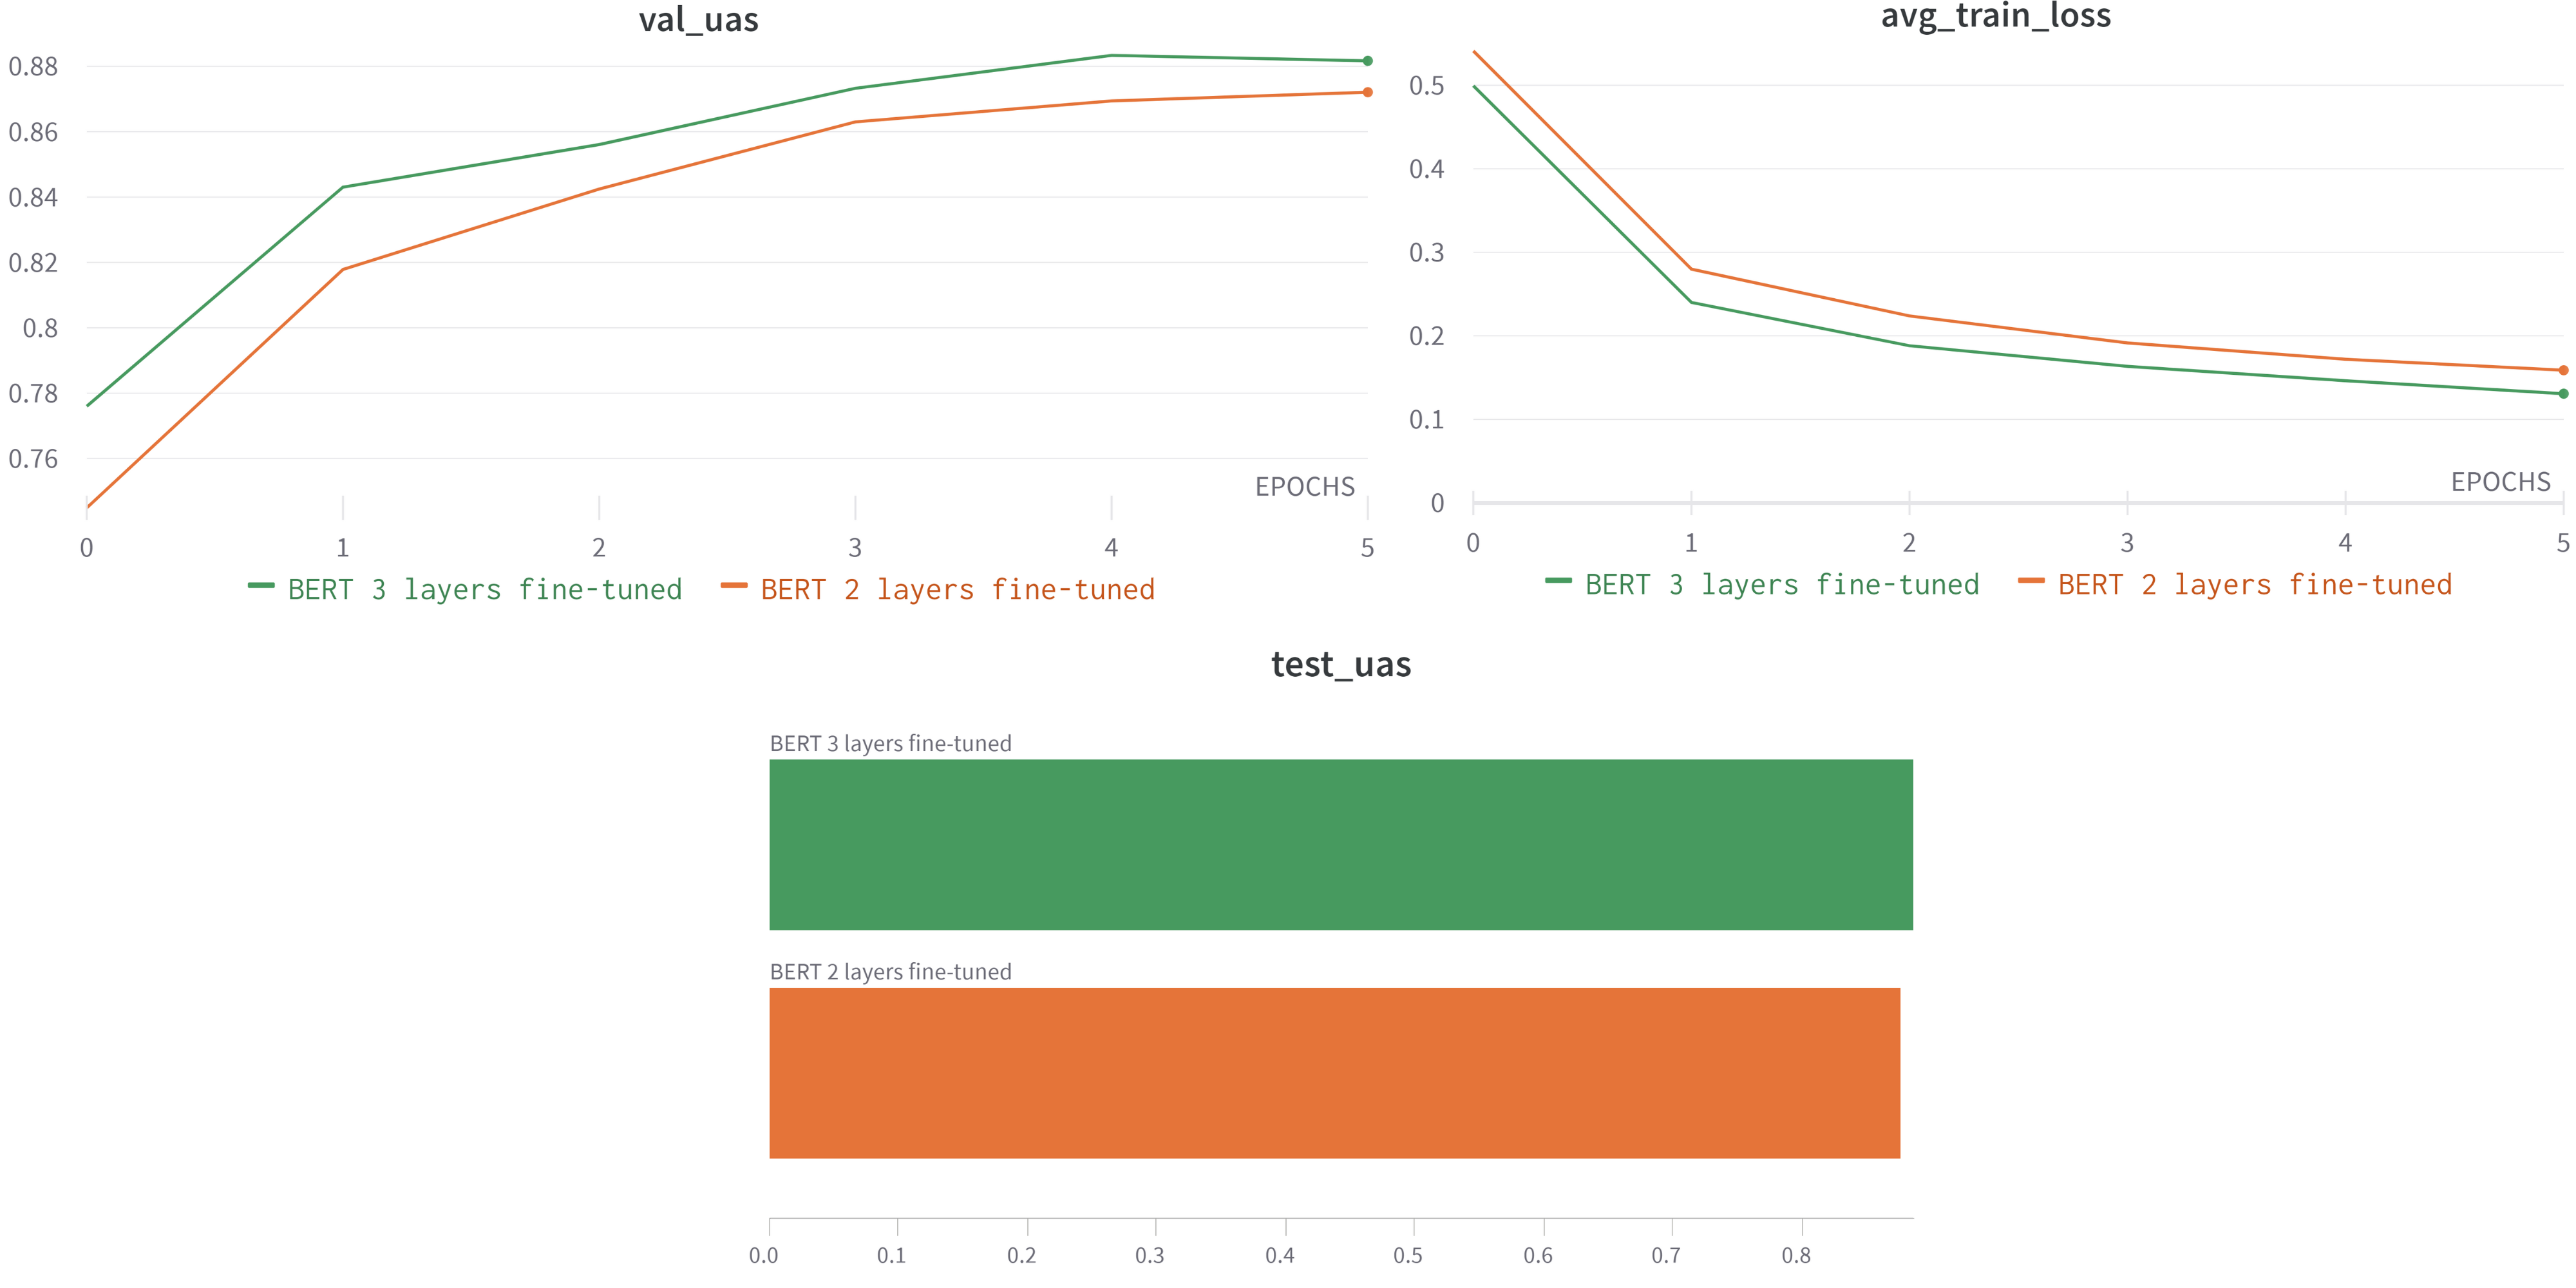

## Comparison between best BERT and BiLSTM models


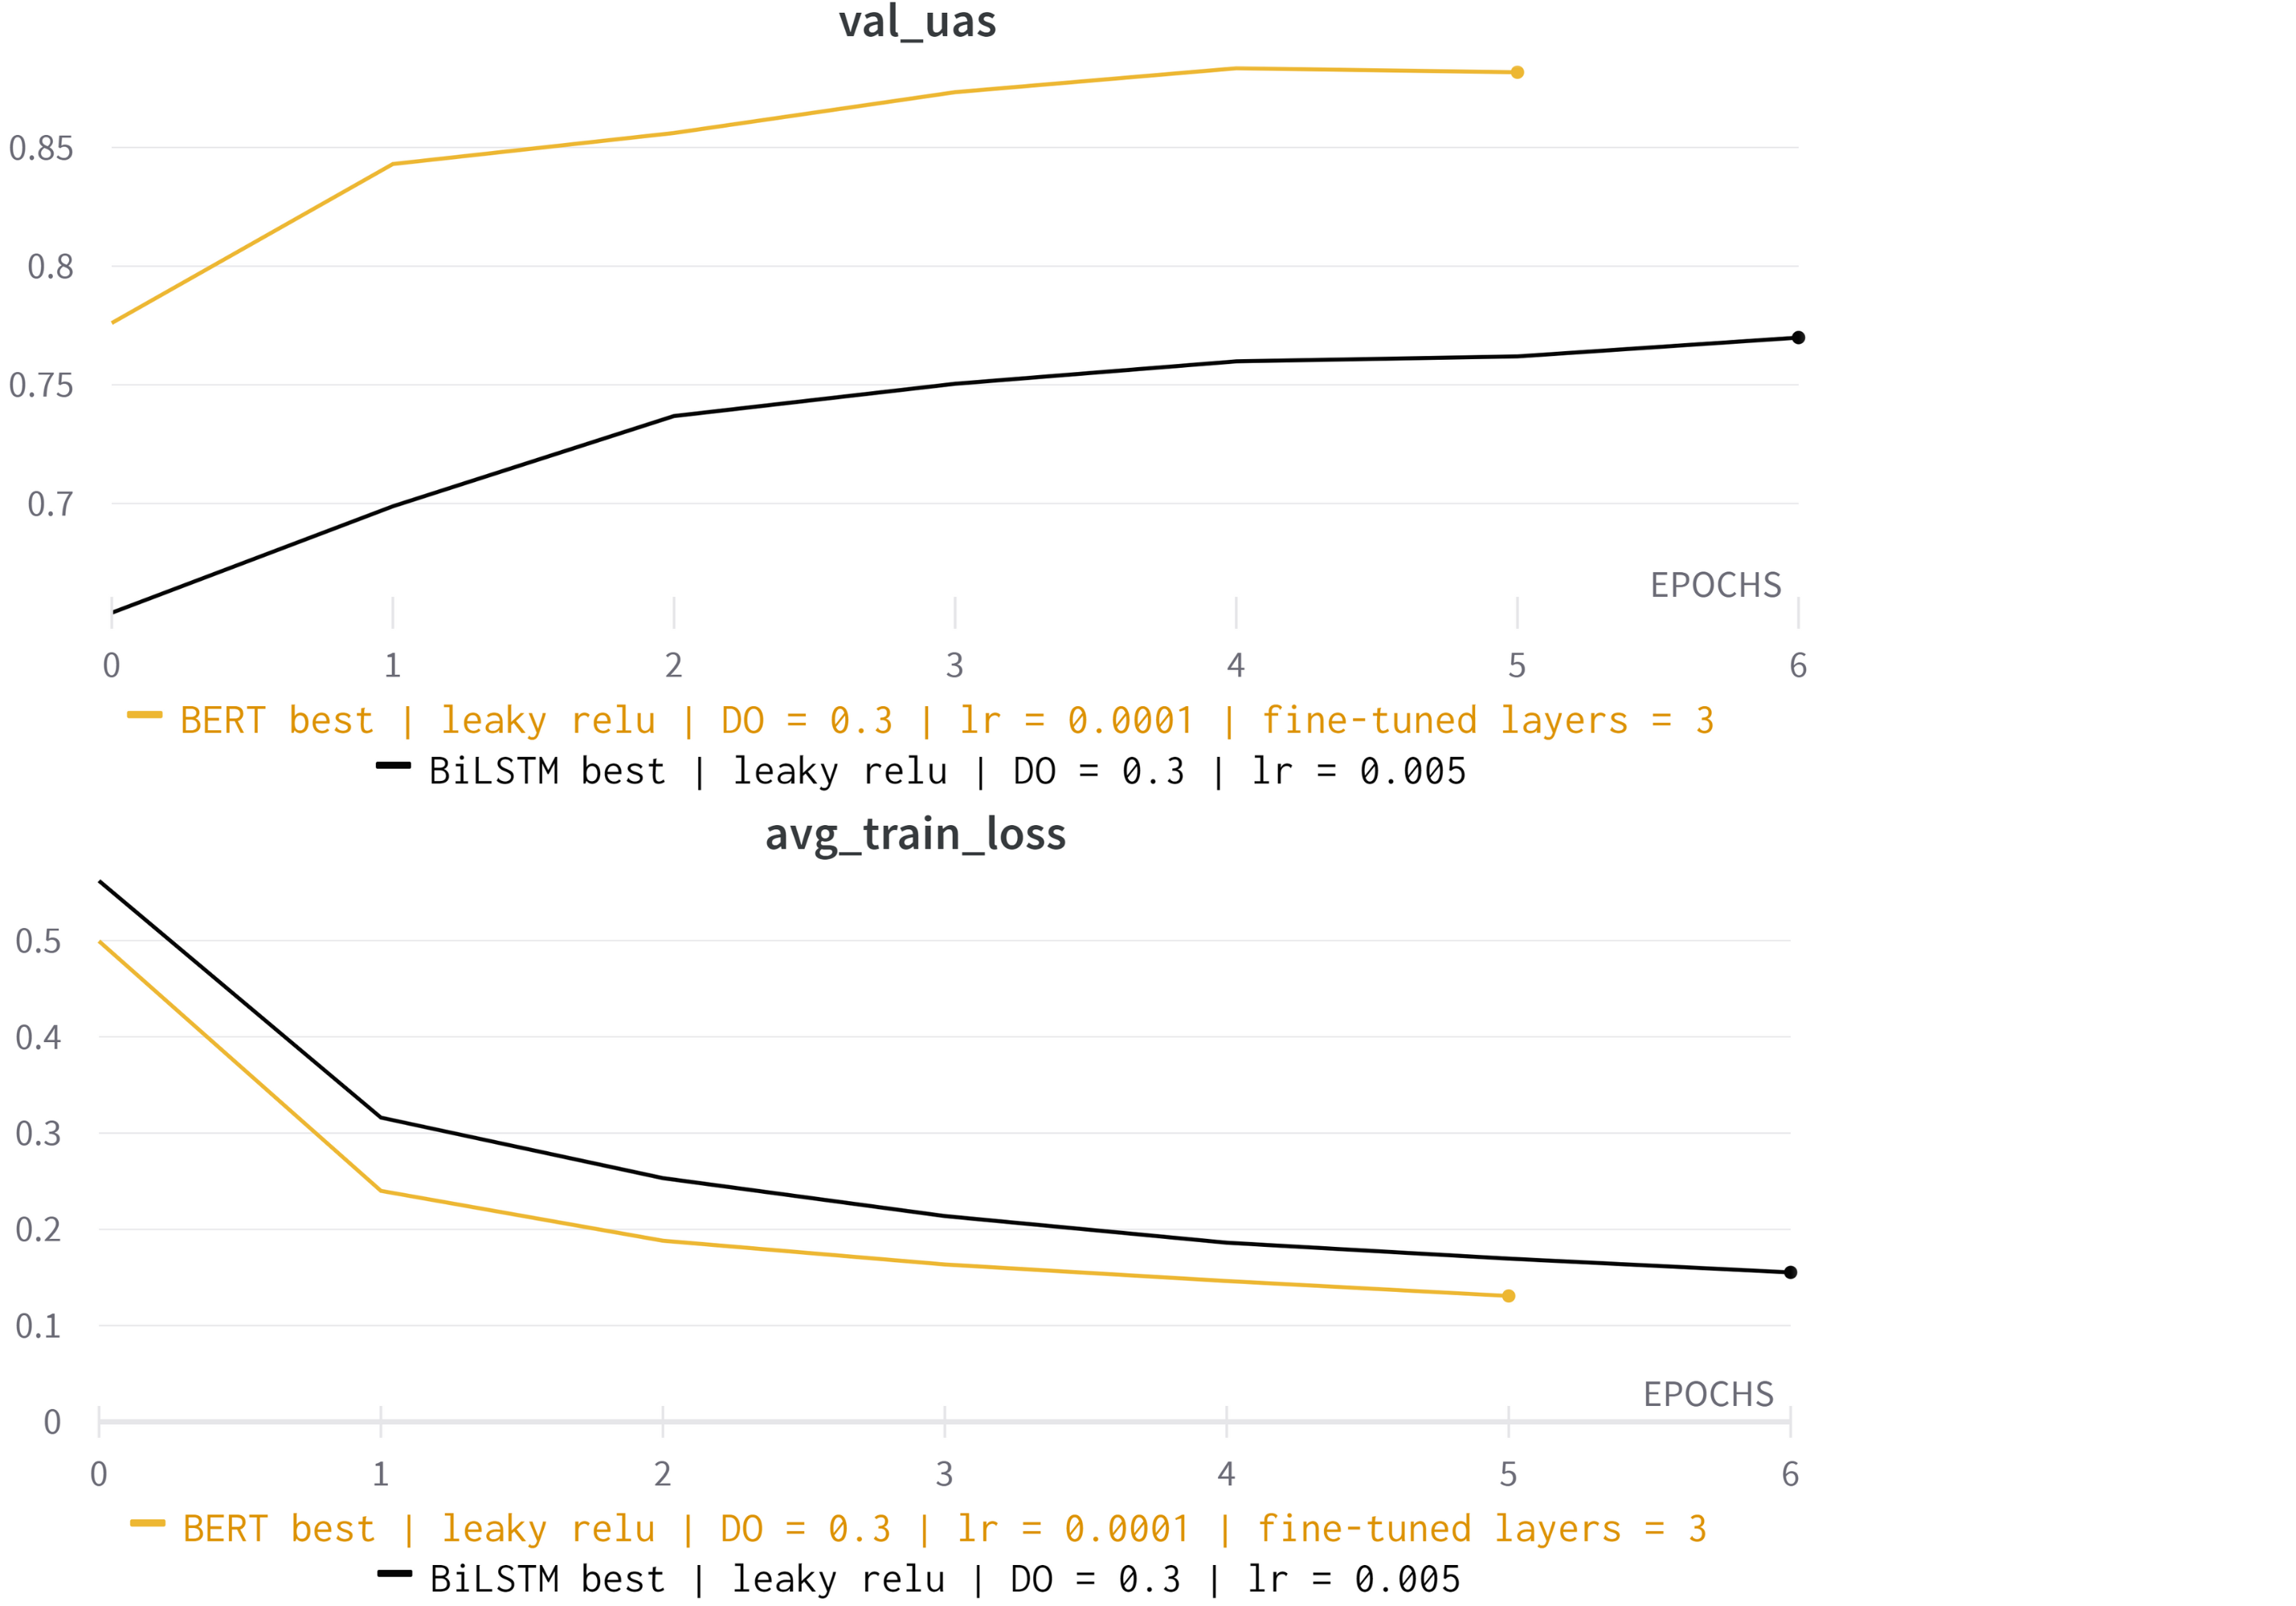

# Error Analysis

The functions defined below are needed to collect all infos about the accuracy of predictions for single moves, percentage of sentence parsed correctly and difference of performance over projective and non projective trees.

In [ ]:
#this function is used to retrieve all the statistics for error analysis, like percentage of sentences parsed correctly ecc


def assess(model,dataloader, BERT = False):
  model.eval()
  count_wrong = 0
  not_projective_count_wrong = 0
  not_projective_count = 0
  projective_count = 0


  predictions_list = []

  true_list = []

  for batch in dataloader:

    if BERT:

        sentences, paths, moves, trees, full_sent = batch
        with torch.no_grad():

          pred, pred_moves = model.infere(sentences, full_sent) #get the predicted trees and moves

    else:

      sentences, paths, moves, trees= batch
      with torch.no_grad():

        pred, pred_moves = model.infere(sentences) # get predicted trees and moves

    for i, j in zip(pred,trees): # counting wrong predicted trees based on projectivity

      if not is_projective(j):

        not_projective_count += 1


      if i != j:

        count_wrong += 1


        if not is_projective(j):
          not_projective_count_wrong += 1

        else:

          projective_count += 1



    for i,j in zip(moves, pred_moves): # getting two single lists with all predictions and ground truths for moves(i.e. transitions)

      if len(i) > len(j):

        i = i[:len(j)]

      elif len(i) < len(j):

        j = j[:len(i)]

      predictions_list.extend([element for element in j])

      true_list.extend([element for element in i])



  assess_dict = {'correct_trees': 1-count_wrong/len(test_dataset), 'not_projective': not_projective_count,

               'wrong_trees': count_wrong, 'projective_wrong': projective_count,

               'not_projective_wrong':not_projective_count_wrong,

               'true_list':true_list, 'predictions_list': predictions_list

               } # dictionary with metrics and statistics

  return assess_dict

In [ ]:
assess_dict = assess(model_bert, test_dataloader, BERT = True)

correct_tree, not_projective, wrong_trees, projective_wrong, not_projective_wrong = (assess_dict['correct_trees'], assess_dict['not_projective'], assess_dict['wrong_trees'],

                                                                                     assess_dict['projective_wrong'], assess_dict['not_projective_wrong'])

true_list, predictions_list = assess_dict['true_list'], assess_dict['predictions_list']

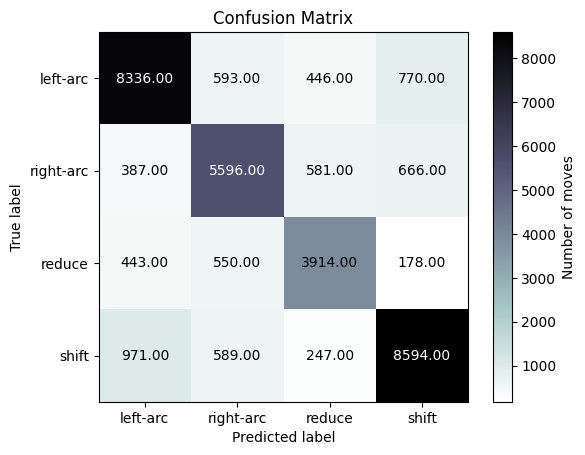



PERFORMANCE METRICS:

╒═══════════╤════════════╤═════════════╤══════════╤═════════╕
│           │   Left-arc │   Right-arc │   Reduce │   Shift │
╞═══════════╪════════════╪═════════════╪══════════╪═════════╡
│ accuracy  │       0.89 │        0.90 │     0.93 │    0.90 │
├───────────┼────────────┼─────────────┼──────────┼─────────┤
│ precision │       0.82 │        0.76 │     0.75 │    0.84 │
├───────────┼────────────┼─────────────┼──────────┼─────────┤
│ recall    │       0.82 │        0.77 │     0.77 │    0.83 │
╘═══════════╧════════════╧═════════════╧══════════╧═════════╛


In [ ]:
#Confusion matrix for prediction of transitions

confusion_m = confusion_matrix(true_list, predictions_list, labels = [0,1,2,3])


disp = ConfusionMatrixDisplay(confusion_matrix=confusion_m, display_labels=['left-arc', 'right-arc', 'reduce', 'shift'])
im = disp.plot(values_format='.2f', cmap='bone_r').im_
fig = plt.gcf()


cbar = fig.axes[-1]

#label of the colorbar
cbar.set_ylabel('Number of moves')

#Title
plt.title('Confusion Matrix')

plt.show()

#/////////////////////////////////

#accuracy, precision and recall computation

conf = confusion_m
accuracy = []

#accuracy

for i in range(len(conf)):
  TP = conf[i,i]

  FN = np.sum(np.delete(conf[i,:], i))
  FP = np.sum(np.delete(conf[:,i], i))
  TN = np.sum(conf) - TP - FN - FP

  accuracy.append(np.round((TP + TN) / (TP + FP + FN + TN),2))

recall = confusion_m.astype('float') / confusion_m.sum(axis=1)[:, np.newaxis]
precision = confusion_m.astype('float') / confusion_m.sum(axis=0)[np.newaxis, :]

recall = np.diag(recall)
precision = np.diag(precision)

table = [['Left-arc','Right-arc', 'Reduce', 'Shift'],
         accuracy,
         precision,
         recall]

#/////////////////////////

#table of evaluation metrics for each transition operator

table = tabulate(table, headers='firstrow', tablefmt='fancy_grid',floatfmt=".2f", showindex = ['accuracy','precision','recall'])


title = '\n\nPERFORMANCE METRICS:'

display_table = f'{title}\n\n{table}'

print(display_table)

Number of incorrectly predicted non-projective trees:	 67  out of  67  non-projective trees in the Test set 




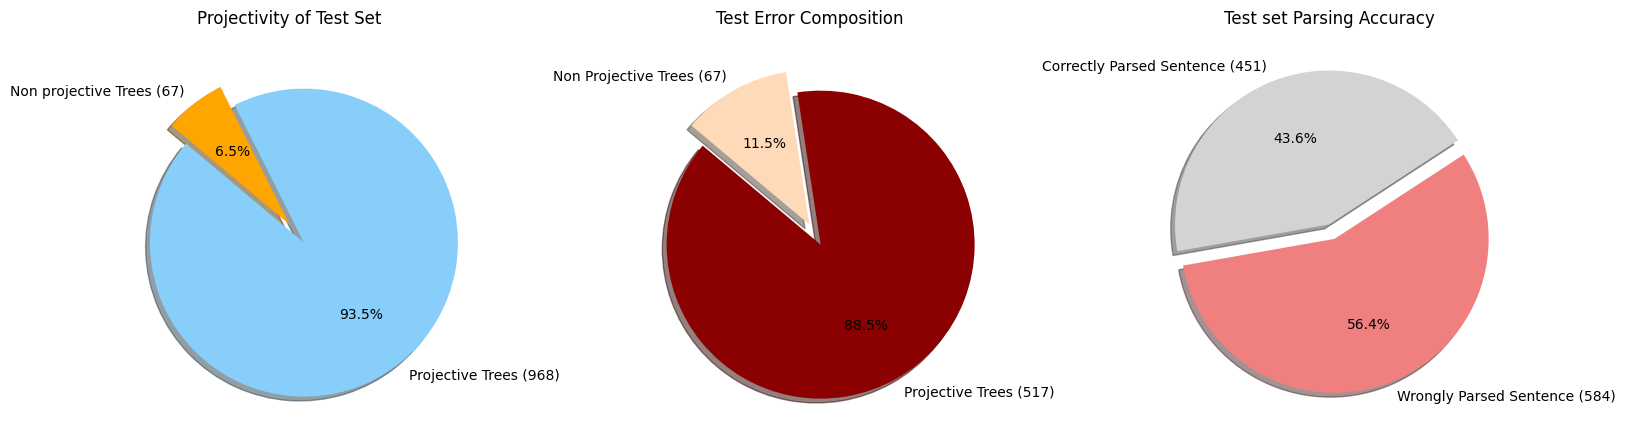

In [ ]:
# summary of the error and decomposition

print("Number of incorrectly predicted non-projective trees:\t", not_projective_wrong,' out of ', not_projective, ' non-projective trees in the Test set', '\n\n')

projective = len(test_dataset) - not_projective

fig, axs = plt.subplots(1,3, figsize = (19,5))

sizes = [projective ,not_projective]
colors = ['lightskyblue','orange']
explodes = (0.15, 0)
labels = 'Projective Trees ({})'.format(projective), 'Non projective Trees ({})'.format(not_projective)

axs[0].pie(sizes, explode = explodes, labels = labels, colors = colors, autopct='%1.1f%%', shadow=True, startangle=140)
axs[0].set_title('Projectivity of Test Set')

sizes = [projective_wrong, not_projective_wrong]
colors = ['darkred','peachpuff']
explodes = (0.15, 0)
labels = 'Projective Trees ({})'.format(projective_wrong), 'Non Projective Trees ({})'.format(not_projective_wrong)

axs[1].pie(sizes, explode = explodes, labels = labels, colors = colors, autopct='%1.1f%%', shadow=True, startangle=140)
axs[1].set_title('Test Error Composition')

total_parsed_wrong = sum(sizes)

colors = ['lightcoral','lightgrey']
sizes = [1-correct_tree, correct_tree]
labels = ['Wrongly Parsed Sentence ({})'.format(total_parsed_wrong),'Correctly Parsed Sentence ({})'.format(len(test_dataset) - total_parsed_wrong)]
explodes = (0.1, 0)
axs[2].pie(sizes, explode = explodes, colors = colors, labels=labels, shadow = True, startangle = 190, autopct = '%1.1f%%')
axs[2].set_title('Test set Parsing Accuracy')
fig.show()

`Reduce` transition yielded the best accuracy (93), while `left-arc` had the worst one (89), although the difference is small. For both, precision and recall, shift has the best scores (respectively: 84,83).

All the `67` non-projective trees were incorrectly predicted. This represents around the `11.5%` of the total error over trees. If we consider only projective trees, the accuracy increase to `53%` up from the initial value of 43.6% in the pie chart.

# State of The Art

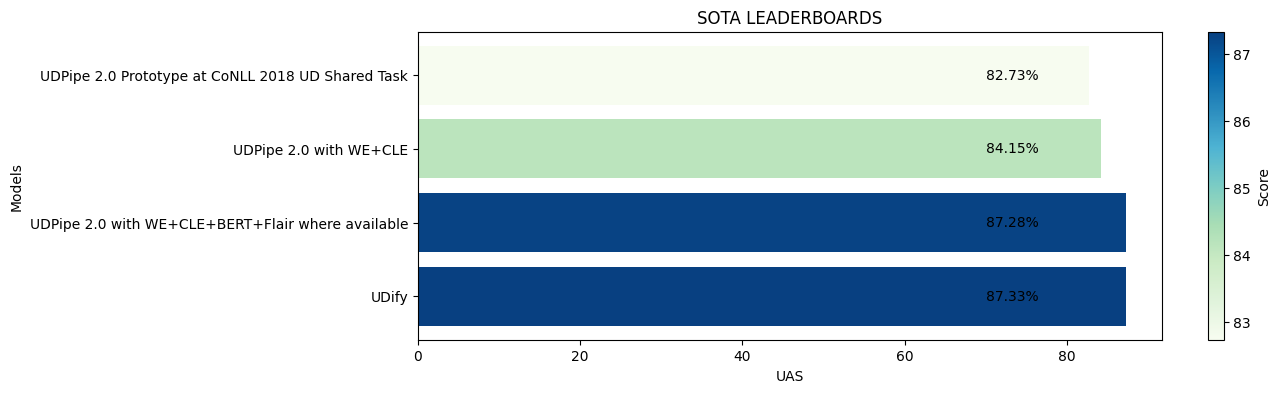

In [ ]:
# barchart of SoTA leaderboards

model_scores = {'UDPipe 2.0 Prototype at CoNLL 2018 UD Shared Task': 82.73,'UDPipe 2.0 with WE+CLE': 84.15,'UDPipe 2.0 with WE+CLE+BERT+Flair where available': 87.28,'UDify': 87.33}

models = list(model_scores.keys())
scores = list(model_scores.values())

fig, ax = plt.subplots(figsize=(12, 4))

cmap = plt.colormaps.get_cmap('GnBu')
normalize = plt.Normalize(vmin=min(scores), vmax=max(scores))
colors = [cmap(normalize(score)) for score in scores]

bars = ax.barh(models, scores, color=colors)

for bar, color in zip(bars, colors):
    width = bar.get_width()
    ax.text(70, bar.get_y() + bar.get_height() / 2, f'{width:.2f}%', ha='left', va='center', color='black')

sm = ScalarMappable(cmap=cmap, norm=normalize)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.05)
cbar.set_label('Score')

ax.set_title('SOTA LEADERBOARDS')
ax.set_xlabel('UAS')
ax.set_ylabel('Models')
ax.invert_yaxis()

plt.show()


State of the art for dependency parsing is established by the UDify model, a multilingual multi-task that can predict dependency trees across 75 languages. The underlying architecture is composed by a multilingual bert pre-trained on 104 languages and fine-tuned on the entirety of UD dataset by concatenating all available training sets together.

* UDify, UDPipe: https://arxiv.org/pdf/1904.02099v3.pdf
*UDPipe 2.0 with WE+CLE+BERT+Flair where available: https://arxiv.org/pdf/1908.07448v1.pdf
* UDPipe 2.0 Prototype at CoNLL 2018 UD Shared Task: https://aclanthology.org/K18-2020.pdf